In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import cv2
import os
import PIL
import random
import SimpleITK as sitk
from albumentations.pytorch import ToTensorV2
import albumentations as A
# Set the path to the file you'd like to load
file_path = "/kaggle/input/rsna-intracranial-hemorrhage-detection"

class HemorrhageDataset(Dataset):
    def __init__(self, path_images, path_label, transform, is_train_val_split=False, is_train_dataset=False):
        self.is_train = is_train_dataset
        self.path_images = path_images
        self.file_path = file_path
        if is_train_val_split == False:
            df = pd.read_csv(f"{file_path}/{path_label}")
            df['ImageName'] = df['ID'].apply(lambda x: x.split("_")[1])
            df['Type'] = df['ID'].apply(lambda x: x.split("_")[2])
            self.df = df
            self.labels_dict = self.df.groupby('ImageName')['Label'].apply(list).to_dict()

            self.image_location = list(self.labels_dict.keys())
            self.file_location = list(map(lambda x: f"{self.file_path}/{self.path_images}/ID_{x}_frame0.png",self.image_location))
            self.transform = len(self.file_location) * [transform]
        else:

            self.df = path_label
            self.labels_dict = self.df.groupby('ImageName')['Label'].apply(list).to_dict()

            self.image_location = list(self.labels_dict.keys())
            self.file_location = list(map(lambda x: f"/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection-png/train_images/ID_{x}_frame0.png",self.image_location))
            self.transform = len(self.file_location) * [transform]




    def __len__(self):
        return len(self.file_location)


    def __apply_filter__(self, image, image_id, not_display=True):
        thresh = 20

        if not_display==False:
            fig, myaxes = plt.subplots(figsize=(20, 10), nrows=3, ncols=2, squeeze=False)

        img = np.array(image, dtype=np.uint8)




        if not_display==False:
            gaussian_image = cv2.GaussianBlur(image, (5, 5), 0)
            bilateral = cv2.bilateralFilter(image, 15, 75, 75)

            gamma = random.choice(list(range(70,131,5)))/100
            gamma_corrected = np.array(255 * (gaussian_image / 255) ** gamma, dtype='uint8')

            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            img_clahe = clahe.apply(image)

            sobelx = cv2.Sobel(img_clahe,cv2.CV_64F,1,0,ksize=5)
            sobely = cv2.Sobel(img_clahe,cv2.CV_64F,0,1,ksize=5)
            edges = cv2.magnitude(sobelx,sobely)
            edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

            _, rib_mask = cv2.threshold(edges, thresh, 255, cv2.THRESH_BINARY)
            myaxes[0][0].set_title("Original image")
            myaxes[0][0].imshow(image, cmap='gray')

            myaxes[0][1].set_title("Gaussian Image")
            myaxes[0][1].imshow(gaussian_image, cmap='gray')

            myaxes[1][0].set_title("Bilateral Image")
            myaxes[1][0].imshow(bilateral, cmap='gray')

            myaxes[1][1].set_title("Gamma corrected")
            myaxes[1][1].imshow(gamma_corrected, cmap='gray')

            myaxes[2][0].set_title("Clahe image")
            myaxes[2][0].imshow(img_clahe, cmap='gray')

            myaxes[2][1].set_title("Rib mask")
            myaxes[2][1].imshow(rib_mask, cmap='gray')
        else:
            rib_mask = image

        rib_mask.resize((224, 224))
        rib_mask = np.array(rib_mask)
        new_image = self.transform[image_id](image=rib_mask)['image']
        new_image = np.squeeze(new_image)
        new_image=np.stack((new_image,)*3, axis=0)

        return new_image


    def __getitem__(self, image_id):

        img_path = self.file_location[image_id]
        our_file = self.image_location[image_id]
        img = PIL.Image.open(img_path)

        new_image = self.__apply_filter__(img, image_id)

        list_elements = np.array(self.labels_dict[our_file], dtype='float32')

        return new_image, list_elements
normal_transform = A.Compose([
    A.Resize(height=224, width=224, p=1),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])
hemDatTest = HemorrhageDataset("rsna-intracranial-hemorrhage-detection-png/test_images", "subdataset_test.csv", normal_transform, False, True)
hemDatTrain = HemorrhageDataset("rsna-intracranial-hemorrhage-detection-png/train_images", "subdataset_train.csv", normal_transform, False, False)


We used dataframe boolean operations to filter elements which are relevant to use, thus being faster and more efficient. We extracted the 'ImageName' which is the name of the image and extracted only those who have the 'Type' equal to 1.

In [ ]:
df2 = pd.DataFrame({'Image':hemDatTrain.df['ImageName'].unique()})

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val =  train_test_split(df2, test_size=0.2, random_state=42)

In [ ]:
files_with_train = X_train['Image'].to_list()
files_with_val = X_val['Image'].to_list()

In [ ]:
files_train = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_train, hemDatTrain.file_location))
files_val = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_val, hemDatTrain.file_location))

In [ ]:
df_Train = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_train['Image'].to_list())]
df_Val = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_val['Image'].to_list())]
df_Train = pd.concat([df_Train], ignore_index=True)
df_Val = pd.concat([df_Val], ignore_index=True)

In [ ]:
hemDatTrain2 = HemorrhageDataset(files_train, df_Train, normal_transform, True, True)
hemDatVal = HemorrhageDataset(files_val, df_Val, normal_transform, True, False)

In [ ]:
special_transform = A.Compose([
    A.Resize(height=224, width=224, p=1),
    A.Rotate(p=0.5, limit=15),
    A.HorizontalFlip(p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.3),
    A.OneOf([
            A.CLAHE(clip_limit=(3,3), p=1),
            A.RandomGamma(gamma_limit=(80.8, 120.2), p=1),
    ], p=0.5),
    A.CoarseDropout(
     num_holes_range=(3, 6),
     hole_height_range=(17.5, 26.25),
     hole_width_range=(17.5, 26.25),
     fill=0,
     p=0.5
    ),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


In [ ]:
special_transform2 = A.Compose([
    A.Resize(height=224, width=224, p=1),
    A.Rotate(p=0.5, limit=15),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.3),
    A.OneOf([
            A.CLAHE(clip_limit=(3,3), p=1),
            A.RandomGamma(gamma_limit=(80.8, 120.2), p=1),
    ], p=0.5),
    A.CoarseDropout(
     num_holes_range=(3, 6),
     hole_height_range=(7, 7),
     hole_width_range=(7, 7),
     fill=0,
     p=0.5
    ),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

In [ ]:
hemDatTrain_augmented2 = HemorrhageDataset(files_train, df_Train, special_transform, True, True)


['any' 'epidural' 'intraparenchymal' 'intraventricular' 'subarachnoid'
 'subdural'] [11644  2407  4592  3736  4355  4229]


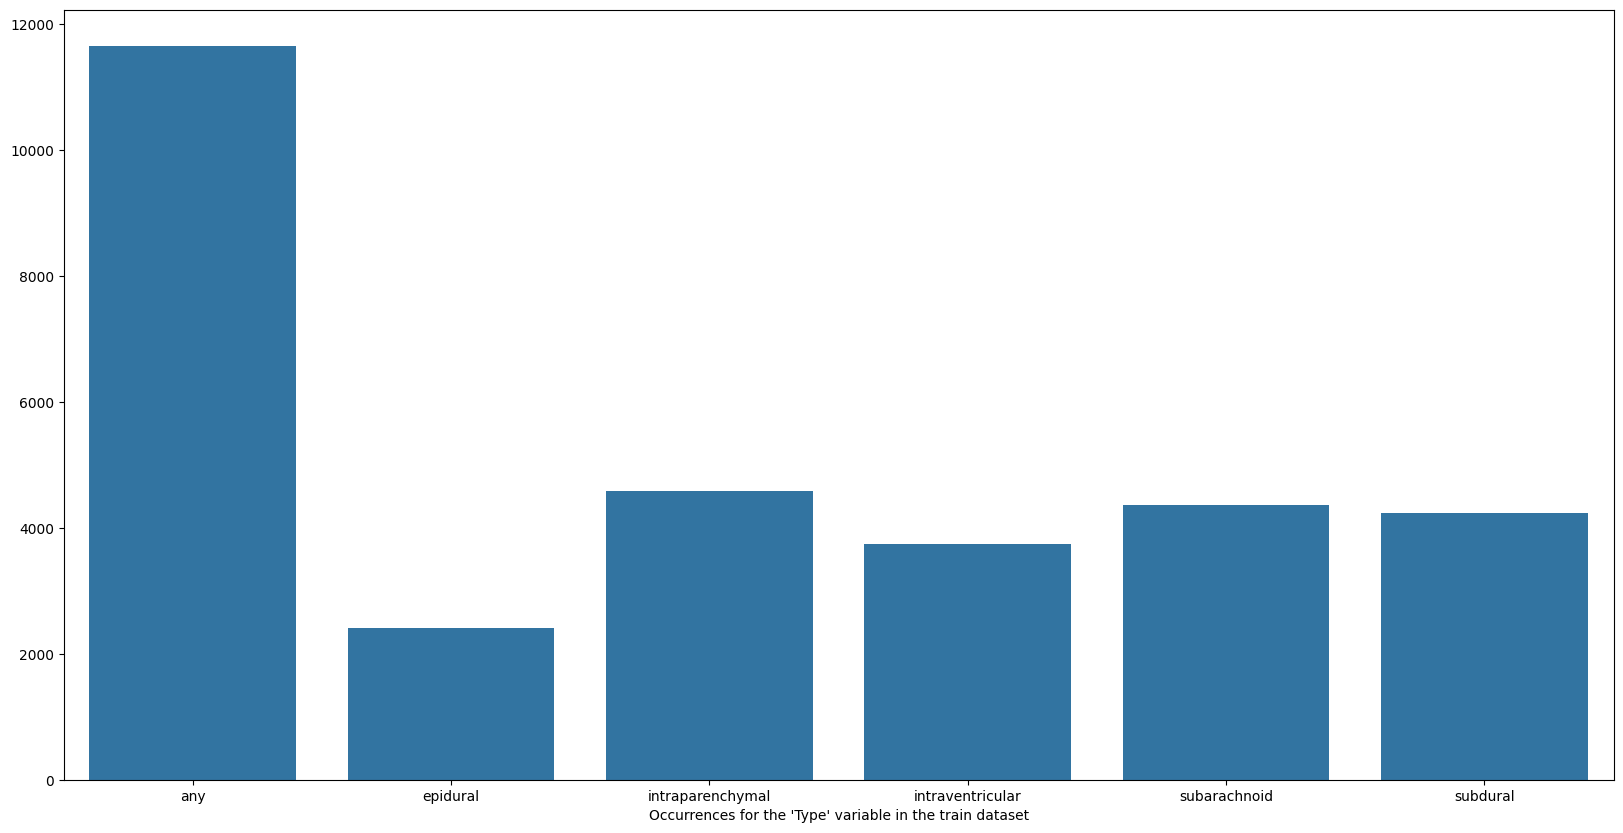

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatTrain2.df[hemDatTrain2.df['Label']==1]['Type'], return_counts=True)
print(val, cnt)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in the train dataset")
sns.barplot(x=val, y=cnt)
plt.show()

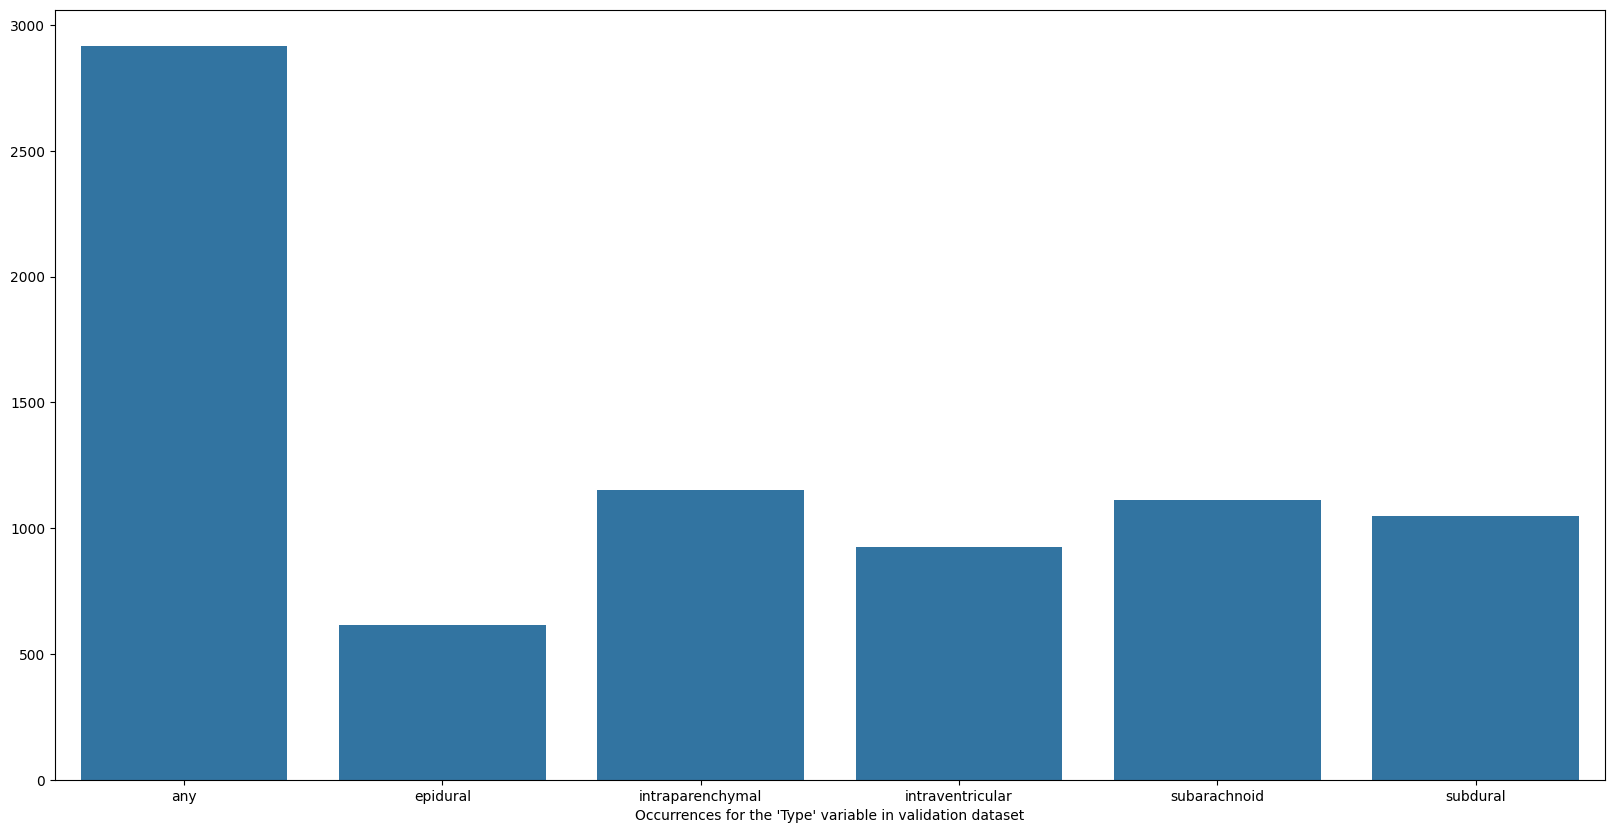

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatVal.df[hemDatVal.df['Label']==1]['Type'], return_counts=True)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in validation dataset")
sns.barplot(x=val, y=cnt)
plt.show()

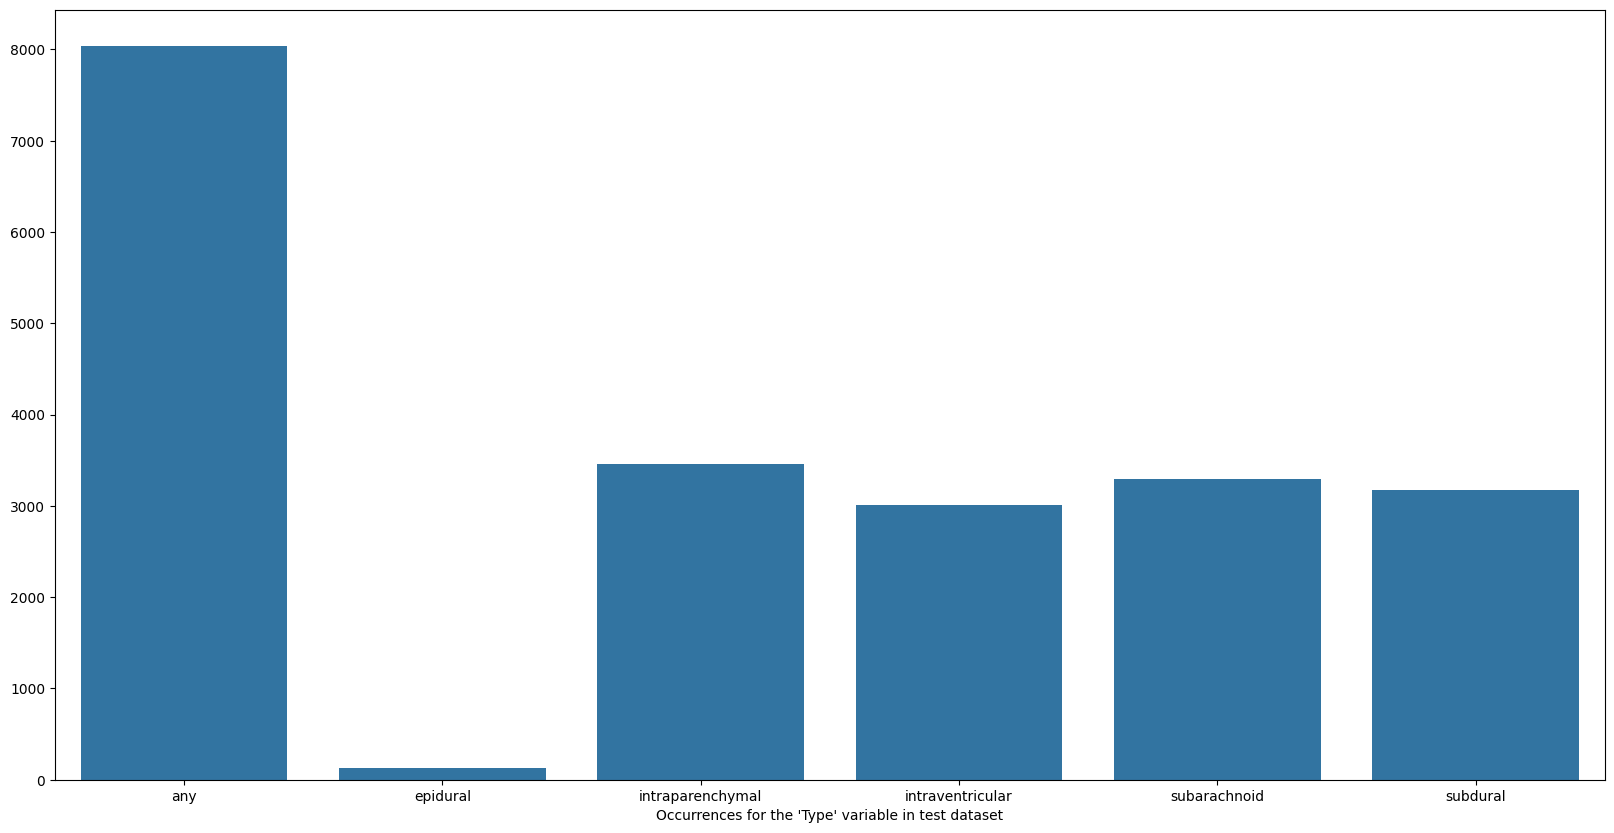

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatTest.df[hemDatTest.df['Label']==1]['Type'], return_counts=True)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in test dataset")
sns.barplot(x=val, y=cnt)
plt.show()

It is obvious that the 'any' variable dominates in the train, validation and test datasets, because it represents whether the other variables are present within an image. In the train and validation dataset, the other variables are not balanced, because the least present variable ('epidural') represents approximately half of the occurrences of the most present variable ('intraparenchymal').

But in the test dataset, 'epidural' is almost non-existant, while have normal proportions.

We could use to handle imbalanced augmentation techniques, SMOTE, oversampling, undersampling or genetic algorithms, which help alleviate this.
We chose to go with the augmentation techniques, which involves

To examine more here

In [ ]:
hemDatVal.most_common_size = (224, 224)
hemDatTest.most_common_size = (224, 224)
hemDatTrain2.most_common_size = (224, 224)


We later try to resize the images

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1.,  1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1.,  1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1.,  1., ..., -1., -1., -1.]]], dtype=float32)

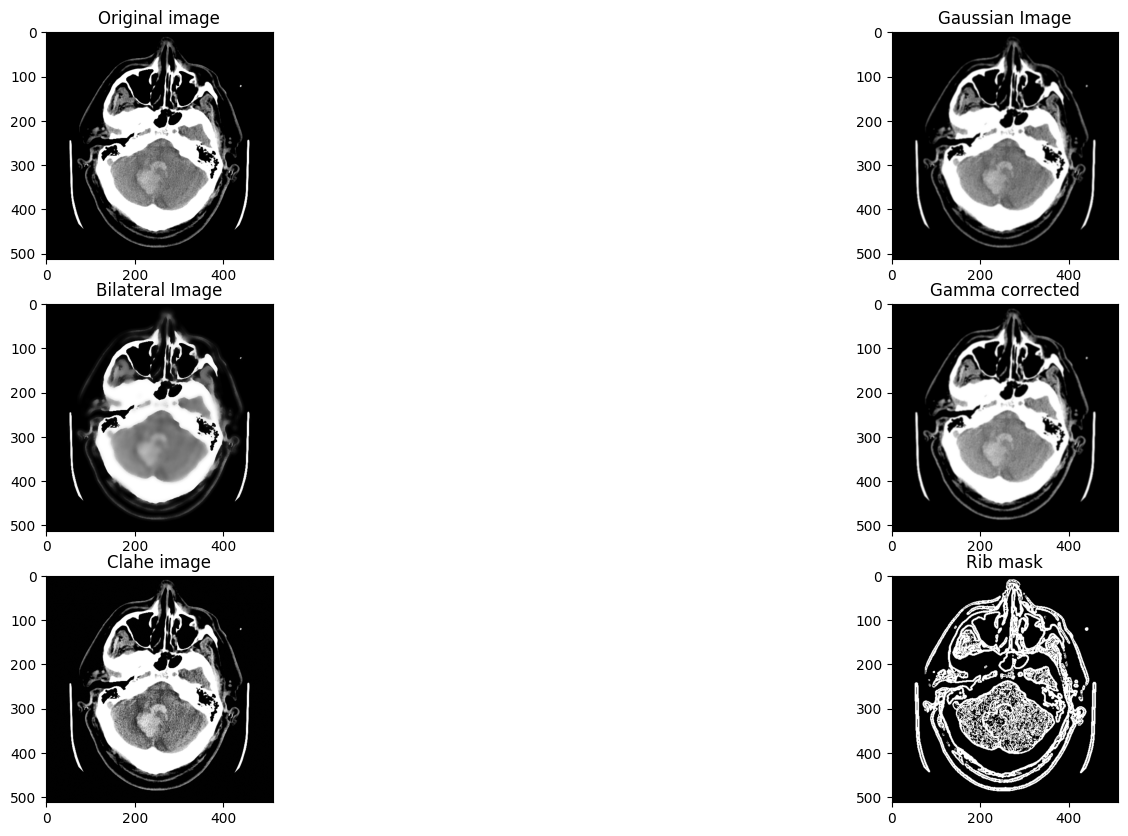

In [ ]:
len_elements = hemDatTrain2.df['Type'].nunique()
elements_list = list(set(map(lambda x: x//len_elements, hemDatTrain2.df.index.to_list())))
number = random.choice(elements_list)
hemDatTrain2.__apply_filter__(np.array(PIL.Image.open(hemDatTrain2.file_location[number])), number, False)

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)

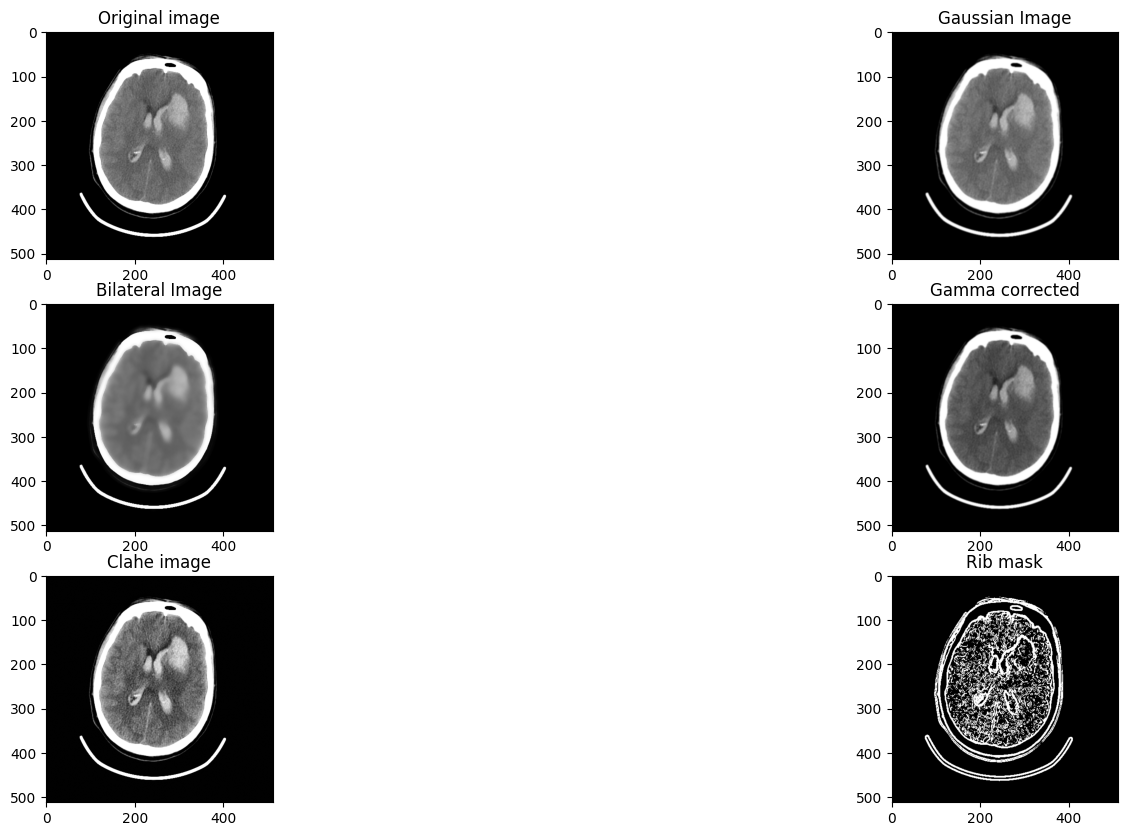

In [ ]:
elements_list = list(set(map(lambda x: x//len_elements, hemDatTest.df.index.to_list())))
number = random.choice(elements_list)
hemDatTest.__apply_filter__(np.array(PIL.Image.open(hemDatTest.file_location[number])),number, False)

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ...,  1.,  1.,  1.],
        [ 1.,  1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ...,  1.,  1.,  1.],
        [ 1.,  1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ...,  1.,  1.,  1.],
        [ 1.,  1., -1., ..., -1., -1., -1.]]], dtype=float32)

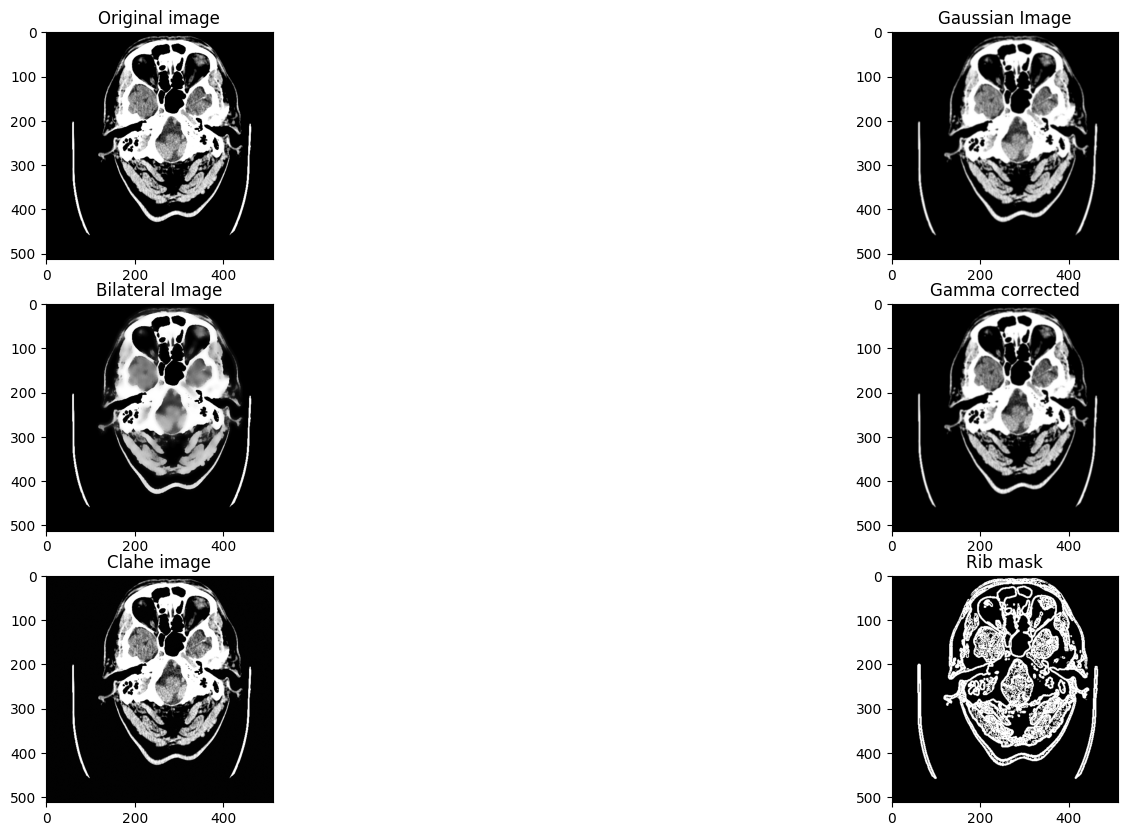

In [ ]:
elements_list = list(set(map(lambda x: x//len_elements, hemDatVal.df.index.to_list())))
number = random.choice(elements_list)
hemDatVal.__apply_filter__(np.array(PIL.Image.open(hemDatVal.file_location[number])),number, False)

We show the transformation for a random image from the train, test, val

In [ ]:
val, cnt = np.unique(hemDatTrain2.df[hemDatTrain2.df['Label']==1]['Type'], return_counts=True)


In [ ]:
from torch.utils.data import Subset
import operator
import torch

def augmentation_function(hemDatTrain2):
    hemDatTrain2_c =  Subset(hemDatTrain2, list(range(len(hemDatTrain2))))

    hemDatTrain2_c.file_location = hemDatTrain2.file_location
    hemDatTrain2_c.df = hemDatTrain2.df
    hemDatTrain2_c.transform = hemDatTrain2.transform
    hemDatTrain2_c.is_train = hemDatTrain2.is_train

    val, cnt = np.unique(hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]['Type'], return_counts=True)
    exclude_any_best_value = max(cnt[1:])
    exclude_any_best_value_index = np.argmax(cnt[1:])+1
    threshold = max(cnt) - min(cnt)

    while threshold > 400:
        for index_col in range(len(val)):
            if index_col == 0 or index_col == exclude_any_best_value_index:
                    continue
            different_elements = hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]
            different_elements= different_elements[different_elements['Type'] == val[index_col]]
            if exclude_any_best_value-cnt[index_col] == 0:
                continue
            elements_to_choose = random.sample(different_elements.index.to_list(), exclude_any_best_value-cnt[index_col])
            index_dif_el = list(map(lambda x: x//6, elements_to_choose))
            remaining_indices = list(set(different_elements.index.to_list()) - set(index_dif_el))
            f_l = operator.itemgetter(*index_dif_el)(hemDatTrain2_c.file_location.copy())
            list_elements = []

            for idx in index_dif_el:
                list_elements.extend(list(range(6*idx, 6*(idx+1))))
            our_df = pd.concat([hemDatTrain2_c.df.loc[list_elements, :]], ignore_index=True)
            our_transformed = operator.itemgetter(*index_dif_el)(hemDatTrain2_c.transform.copy())

            subset_dataset = Subset(hemDatTrain2_c, index_dif_el)
            my_final_list = hemDatTrain2_c.file_location.copy()
            Transforms = hemDatTrain2_c.transform.copy()

            df_og = hemDatTrain2_c.df

            hemDatTrain2_c = torch.utils.data.ConcatDataset([hemDatTrain2_c, subset_dataset])
            my_final_list.extend(f_l)

            hemDatTrain2_c.file_location = my_final_list

            our_df = pd.concat([df_og, our_df], ignore_index=True)
            hemDatTrain2_c.df = our_df


            Transforms.extend(our_transformed)

            hemDatTrain2_c.transform = Transforms
            hemDatTrain2_c.is_train = hemDatTrain2.is_train
        val, cnt = np.unique(hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]['Type'], return_counts=True)
        threshold = max(cnt[1:]) - min(cnt[1:])
        exclude_any_best_value = max(cnt[1:])
        exclude_any_best_value_index = np.argmax(cnt[1:])+1
    return hemDatTrain2_c



We try to balance the type, by inserting image augmentations, and we stop until the difference between the maximum and minimum is less than 400.

In [ ]:
hemDatTrain2_c=augmentation_function(hemDatTrain_augmented2)

[18872  6552  6907  6577  6818  6691]


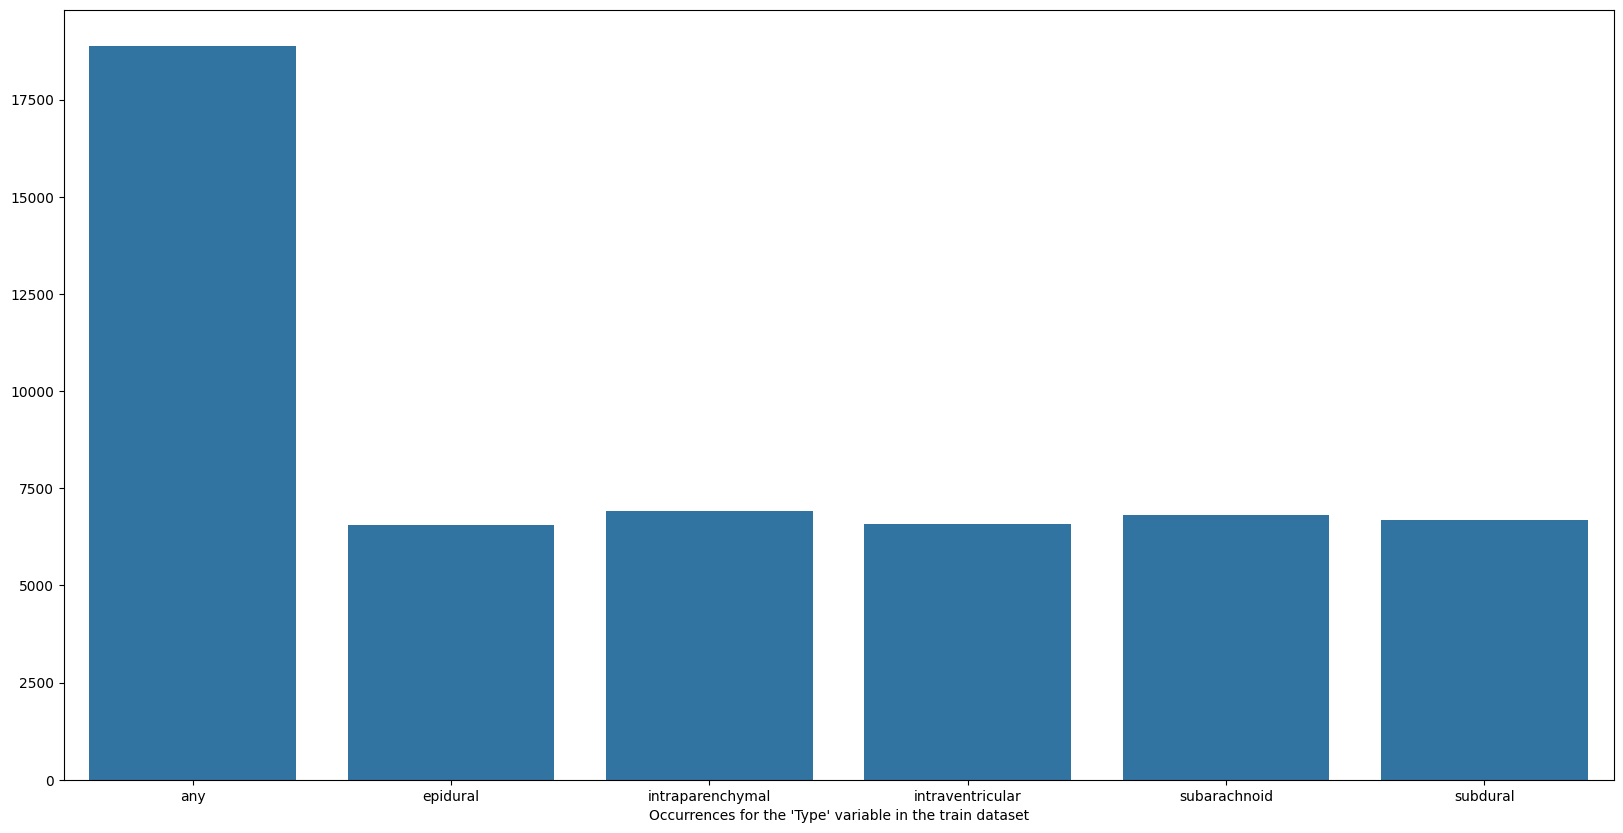

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]['Type'], return_counts=True)
plt.figure(figsize=(20, 10))
print(cnt)
plt.xlabel(f"Occurrences for the 'Type' variable in the train dataset")
sns.barplot(x=val, y=cnt)
plt.show()

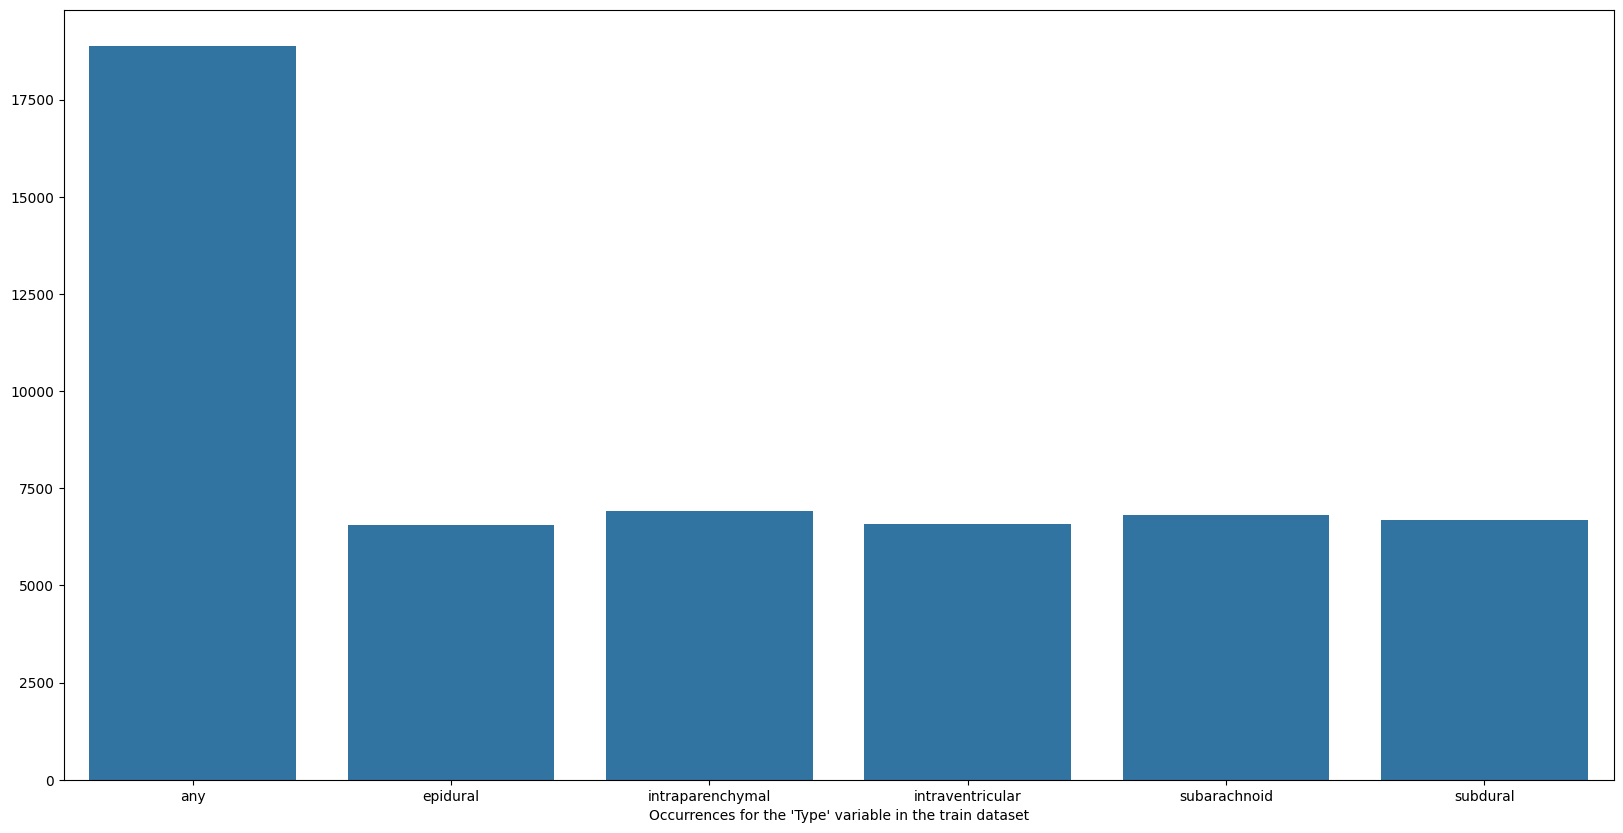

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]['Type'], return_counts=True)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in the train dataset")
sns.barplot(x=val, y=cnt)
plt.show()

In [ ]:
batch_size = 16
import torch
train_loader = torch.utils.data.DataLoader(hemDatTrain2_c, batch_size = batch_size, shuffle = True, num_workers=4)
val_loader = torch.utils.data.DataLoader(hemDatVal, batch_size = batch_size, shuffle = True, num_workers=4)
test_loader = torch.utils.data.DataLoader(hemDatTest, batch_size = batch_size, shuffle = True, num_workers=4)

In [ ]:
val_shape = ()
out_shape = ()
for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
    for X, y in value:
        val_shape = X.shape
        out_shape = y.shape

        print(f"Shape of X : {X.shape}")
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Shape of X : torch.Size([16, 3, 224, 224])
Training data:
Shape of X : torch.Size([16, 3, 224, 224])
Shape of y: torch.Size([16, 6]) torch.float32

Shape of X : torch.Size([16, 3, 224, 224])
Validation data:
Shape of X : torch.Size([16, 3, 224, 224])
Shape of y: torch.Size([16, 6]) torch.float32

Shape of X : torch.Size([16, 3, 224, 224])
Test data:
Shape of X : torch.Size([16, 3, 224, 224])
Shape of y: torch.Size([16, 6]) torch.float32



In [ ]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None, scaler=None):

    use_amp = True

    with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
        loss = loss_func(output, target)
        pred = (nn.Sigmoid()(output)>0.5).float()  # Get Output Class
        metric_b = (pred == target).all(dim=1).float().sum().item()
    if opt is not None:
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None, scaler=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output

        loss_b,metric_b=loss_batch(loss_func, output, yb, opt, scaler=scaler) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [ ]:
from tqdm.notebook import trange, tqdm
import time
time_current = None
def Train_Val(model, params,verbose=False, limit=False, s=None):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    previous_loss = best_loss
    early_stop_it = 0
    use_amp = True

    scaler = torch.amp.GradScaler("cuda", use_amp)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt, scaler=scaler)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        if (s!=None):
            global time_current
            time_current = time.time() - s


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl, scaler=scaler)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
            early_stop_it=0
        else:
            early_stop_it+=1

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        if lr_scheduler is not None:
          lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*(val_metric):.2f}")
        print("-"*10)




        if limit and early_stop_it > 2:
            break

        previous_loss = val_loss


    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history, best_model_wts

In [ ]:
def Ture_and_Pred(val_loader, model, device):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        pred = (nn.Sigmoid()(outputs)>0.5).float()
        y_true.extend(labels)
        y_pred.extend(pred.detach().cpu())

    return y_true, y_pred

def get_pos_weights(df):
    weights_all = []
    for cols in df['Type'].unique():
        df_type = df[df['Type']==cols]
        num_neg = len(df_type[df_type['Label']==0])
        num_pos = len(df_type[df_type['Label']==1])
        weights = num_neg / (num_pos + 1e-5)
        weights_all.append(weights)
    return torch.as_tensor(weights_all)
num_weight = get_pos_weights(hemDatTrain2.df)


In [ ]:
if len(hemDatTrain2.df) % 6 == 0:
    print("IS OKAY")

IS OKAY


https://stackoverflow.com/questions/57021620/how-to-calculate-unbalanced-weights-for-bcewithlogitsloss-in-pytorch

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset

def get_sampler_pos_weight(df, num_weight):
    healthy_weight = max(torch.min(num_weight),1.0)
    id_el = 0
    sampler_weights = []
    for id_name in df['ImageName'].unique():
        values = list(df[id_el:id_el+6]['Label'])
        if values.count(1) != 0:
            my_val = np.max([num_weight[i] * values[i] for i in range(len(values))])
            sampler_weights.append(my_val)
        else:
            sampler_weights.append(healthy_weight)

        id_el+=6
    return torch.as_tensor(sampler_weights)




Shape of X : torch.Size([64, 3, 224, 224])
Training data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32

Shape of X : torch.Size([64, 3, 224, 224])
Validation data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32

Shape of X : torch.Size([64, 3, 224, 224])
Test data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004955, dev loss: 0.005455, accuracy: 63.70
----------
Epoch 1/9, current lr=0.0001
train loss: 0.004219, dev loss: 0.007178, accuracy: 35.62
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.003850, dev loss: 0.004065, accuracy: 62.33
----------
Epoch 3/9, current lr=0.0001
train loss: 0.003473, dev loss: 0.005062, accuracy: 52.35
----------
Epoch 4/9, current lr=0.0001
train loss: 0.003037, dev loss: 0.007610, accuracy: 65.80
----------
Epoch 5/9, current lr=0.0001
train loss: 0.002526, dev loss: 0.004822, accuracy: 67.03
----------
Epoch 6/9, current lr=0.0001
train loss: 0.002055, dev loss: 0.004349, accuracy: 62.19
----------
Epoch 7/9, current lr=0.0001
train loss: 0.001581, dev loss: 0.006321, accuracy: 51.32
----------
Epoch 8/9, current lr=0.0001
train loss: 0.001150, dev loss: 0.005783, accuracy: 66.98
----------
Epoch 9/9, current lr=0.0001
train loss: 0.000894, dev loss: 0.0

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004941, dev loss: 0.006132, accuracy: 64.21
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.004174, dev loss: 0.004245, accuracy: 61.08
----------
Epoch 2/9, current lr=0.0001
train loss: 0.003802, dev loss: 0.004295, accuracy: 59.73
----------
Epoch 3/9, current lr=0.0001
train loss: 0.003429, dev loss: 0.004248, accuracy: 59.42
----------
Epoch 4/9, current lr=0.0001
train loss: 0.002941, dev loss: 0.004449, accuracy: 61.24
----------
Epoch 5/9, current lr=0.0001
train loss: 0.002459, dev loss: 0.004758, accuracy: 53.83
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001956, dev loss: 0.006360, accuracy: 66.88
----------
Epoch 7/9, current lr=0.0001
train loss: 0.001514, dev loss: 0.005522, accuracy: 68.69
----------
Epoch 8/9, current lr=0.0001
train loss: 0.001095, dev loss: 0.006256, accuracy: 53.44
----------
Epoch 9/9, current lr=0.0001
train loss: 0.000823, dev loss: 0.0

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004946, dev loss: 0.004508, accuracy: 60.72
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.004166, dev loss: 0.004431, accuracy: 64.87
----------
Epoch 2/9, current lr=0.0001
train loss: 0.003758, dev loss: 0.004621, accuracy: 65.92
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.003328, dev loss: 0.003865, accuracy: 65.04
----------
Epoch 4/9, current lr=0.0001
train loss: 0.002836, dev loss: 0.005633, accuracy: 65.59
----------
Epoch 5/9, current lr=0.0001
train loss: 0.002288, dev loss: 0.005101, accuracy: 67.84
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001752, dev loss: 0.006071, accuracy: 56.70
----------
Epoch 7/9, current lr=0.0001
train loss: 0.001280, dev loss: 0.006827, accuracy: 68.02
----------
Epoch 8/9, current lr=0.0001
train loss: 0.000960, dev loss: 0.007678, accuracy: 67.22
----------
Epoch 9/9, current lr=0.0001
train lo

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004912, dev loss: 0.004318, accuracy: 61.19
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.004159, dev loss: 0.004249, accuracy: 57.45
----------
Epoch 2/9, current lr=0.0001
train loss: 0.003792, dev loss: 0.004379, accuracy: 66.20
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.003385, dev loss: 0.003749, accuracy: 65.11
----------
Epoch 4/9, current lr=0.0001
train loss: 0.002942, dev loss: 0.005743, accuracy: 66.36
----------
Epoch 5/9, current lr=0.0001
train loss: 0.002438, dev loss: 0.004479, accuracy: 57.87
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001984, dev loss: 0.004711, accuracy: 56.27
----------
Epoch 7/9, current lr=0.0001
train loss: 0.001485, dev loss: 0.007208, accuracy: 46.82
----------
Epoch 8/9, current lr=0.0001
train loss: 0.001124, dev loss: 0.005253, accuracy: 58.60
----------
Epoch 9/9, current lr=0.0001
train lo

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004921, dev loss: 0.005100, accuracy: 63.07
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.004148, dev loss: 0.004233, accuracy: 58.50
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.003752, dev loss: 0.003923, accuracy: 62.23
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.003298, dev loss: 0.003873, accuracy: 65.72
----------
Epoch 4/9, current lr=0.0001
train loss: 0.002766, dev loss: 0.004627, accuracy: 54.35
----------
Epoch 5/9, current lr=0.0001
train loss: 0.002200, dev loss: 0.004576, accuracy: 58.41
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001641, dev loss: 0.004698, accuracy: 65.97
----------
Epoch 7/9, current lr=0.0001
train loss: 0.001163, dev loss: 0.005297, accuracy: 65.44
----------
Epoch 8/9, current lr=0.0001
train loss: 0.000858, dev loss: 0.006065, accuracy: 64.96
----------
Epoch 9/9,

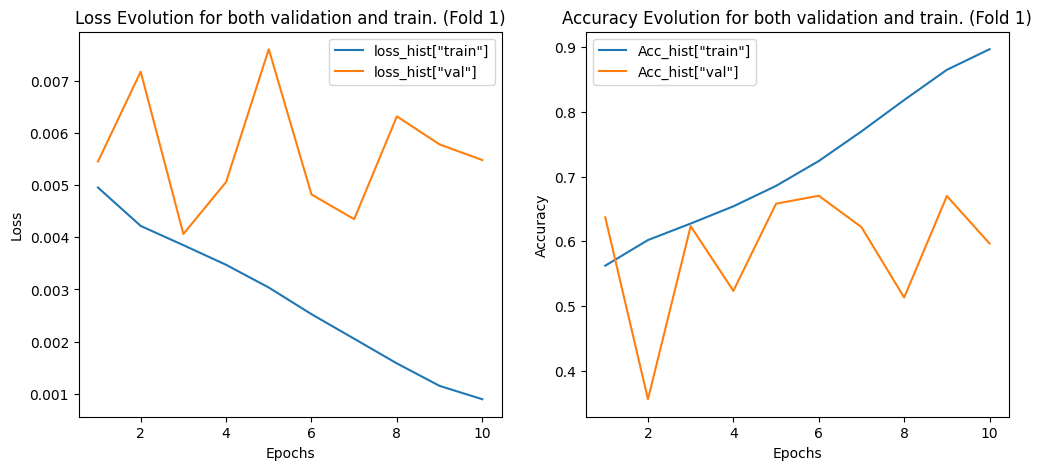

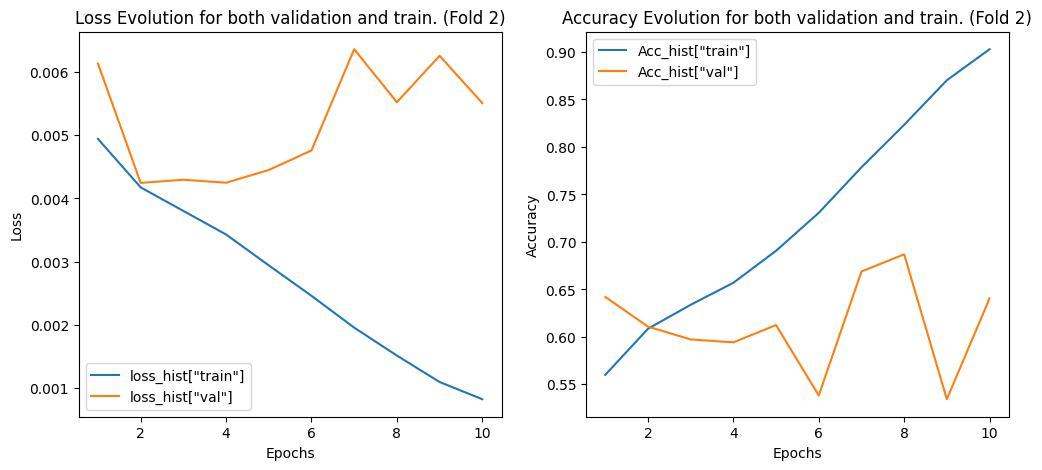

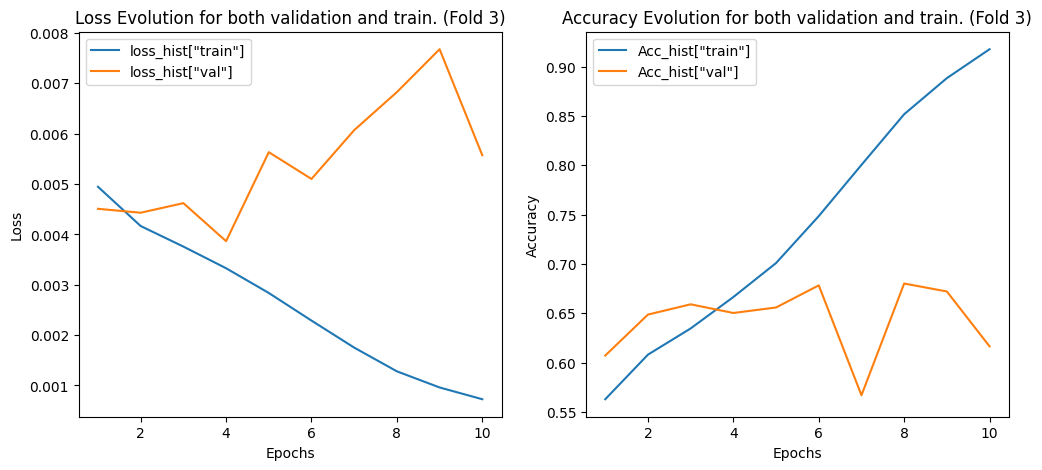

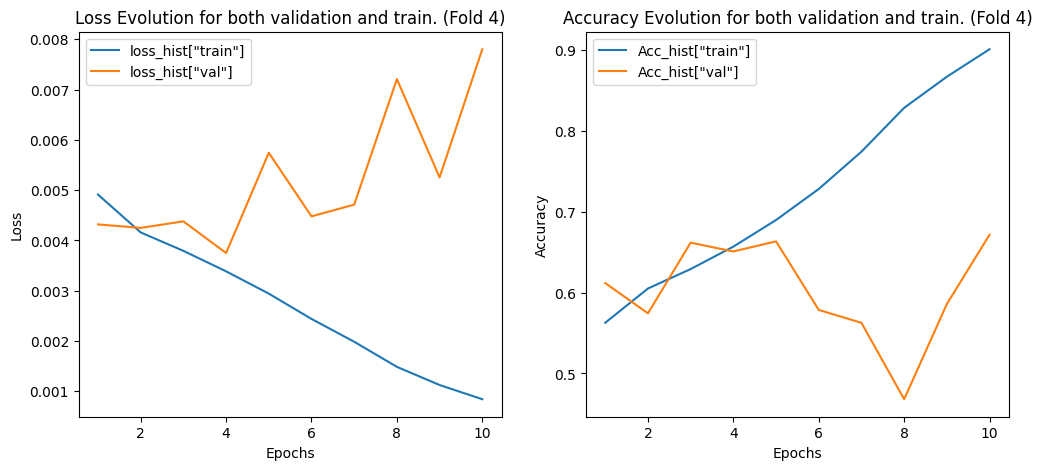

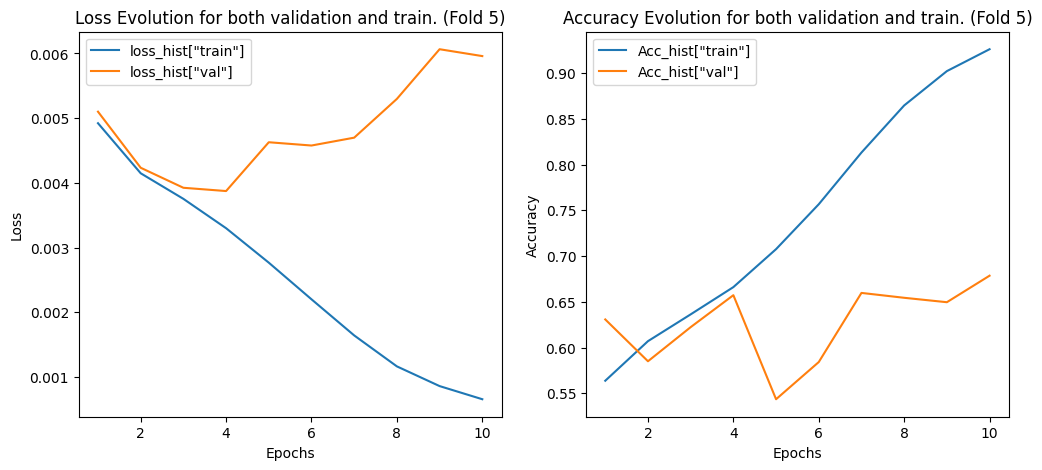

In [ ]:
k = 5  # Number of folds
import copy
import torchvision
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
from torchvision.models import resnet18, ResNet18_Weights,efficientnet_b4
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, hamming_loss, precision_score, accuracy_score
kf = KFold(n_splits=k, shuffle=True, random_state=42)

metric_hist_list = []
loss_hist_list = []
resnet_model_list = []
best_model_wts_list = []


min_worst_f1_score = float('inf')
val_min_index = []
train_min_index = []

max_best_f1_score = -float('inf')
val_max_index = []
train_max_index = []
max_fold = -1

val_index2 = []
min_fold = -1
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []
loss_b = []

accuracy_list2 = []
precision_list2 = []
recall_list2 = []
f1_score_list2 = []
hamming_list = []
hamming_list2 = []


val_loss = []
val_acc = []
train_loss = []
train_acc = []
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
loss_b2 = []
for fold, (train_index, val_index) in enumerate(kf.split(df2)):
    cnn_model = resnet18(weights=None)

    num_ftrs = cnn_model.fc.in_features
    cnn_model.fc = nn.Linear(num_ftrs, 6)
    if torch.cuda.is_available():
        cnn_model.cuda()

    if torch.cuda.device_count() > 1:
        cnn_model = nn.DataParallel(cnn_model)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    cnn_model.to(device)
    X_train = df2.loc[train_index]
    X_val = df2.loc[val_index]
    val_index2 = val_index
    files_with_train = X_train['Image'].to_list()
    files_with_val = X_val['Image'].to_list()
    files_train = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_train, hemDatTrain.file_location))
    files_val = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_val, hemDatTrain.file_location))
    df_Train = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_train['Image'].to_list())]
    df_Val = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_val['Image'].to_list())]
    df_Val = pd.concat([df_Val], ignore_index=True)
    df_Train = pd.concat([df_Train], ignore_index=True)


    hemDatTrain3 = HemorrhageDataset(files_train, df_Train, normal_transform, True, True)
    hemDatVal2 = HemorrhageDataset(files_val, df_Val, normal_transform, True, False)


    batch_size = 64

    num_weight = get_pos_weights(hemDatTrain3.df)
    sampler_pos_weight = get_sampler_pos_weight(hemDatTrain3.df, num_weight)
    num_weight = num_weight.to(device)
    sampler = WeightedRandomSampler(sampler_pos_weight, len(sampler_pos_weight))




    train_loader = torch.utils.data.DataLoader(hemDatTrain3, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(hemDatVal2, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(hemDatTest, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)

    val_shape = ()
    out_shape = ()
    for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
        for X, y in value:
            val_shape = X.shape
            out_shape = y.shape

            print(f"Shape of X : {X.shape}")
            print(f"{key}:")
            print(f"Shape of X : {X.shape}")
            print(f"Shape of y: {y.shape} {y.dtype}\n")
            break


    params_train={
     "train": train_loader,"val": val_loader,
     "epochs": 10,
     "optimiser": optim.Adam(cnn_model.parameters(),lr=1e-4, weight_decay=1e-4),
     "lr_change": None,
     "f_loss": torch.nn.BCEWithLogitsLoss(),
     "weight_path": "weights.pt",
    }

    resnet_model,loss_hist,metric_hist,best_model_wts = Train_Val(cnn_model,params_train, verbose=True)
    metric_hist_list.append(metric_hist)
    loss_hist_list.append(loss_hist)
    resnet_model_list.append(resnet_model)
    best_model_wts_list.append(best_model_wts)
    for idx, (train, val) in enumerate(zip(metric_hist['train'], metric_hist['val'])):
        print(f"Iteration {idx}. Accurracy for train :{train*100}. Accurracy for val :{val*100}")
    for idx, (train, val) in enumerate(zip(loss_hist['train'], loss_hist['val'])):
        print(f"Iteration {idx}. Loss for train :{train}. Loss for val :{val}")


    # Convergence History Plot
    epochs=params_train["epochs"]
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    list_metric_train = list(map(lambda x: x, metric_hist["train"]))
    list_metric_val = list(map(lambda x: x, metric_hist["val"]))

    sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
    sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')

    ax[0].set_title(f"Loss Evolution for both validation and train. (Fold {fold+1})")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    sns.lineplot(x=[*range(1,epochs+1)],y=list_metric_train,ax=ax[1],label='Acc_hist["train"]')
    sns.lineplot(x=[*range(1,epochs+1)],y=list_metric_val,ax=ax[1],label='Acc_hist["val"]')
    ax[1].set_title(f"Accuracy Evolution for both validation and train. (Fold {fold+1})")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    loss_func = torch.nn.BCEWithLogitsLoss()
    y_true, y_pred = Ture_and_Pred(test_loader, resnet_model, device)

    metric_b=accuracy_score(y_pred, y_true)
    _acc = metric_b
    _f1_score = f1_score(y_true, y_pred, average='macro')
    _recall = recall_score(y_true, y_pred, average='macro')
    _precision = precision_score(y_true, y_pred, average='macro')
    _hamming = hamming_loss(y_true, y_pred)
    accuracy_list.append(_acc)
    precision_list.append(_precision)
    recall_list.append(_recall)
    f1_score_list.append(_f1_score)
    hamming_list.append(_hamming)


    print(f"For test:\n accuracy:{metric_b}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n hamming_score{1-_hamming}\n ")



    y_true, y_pred = Ture_and_Pred(val_loader, resnet_model, device)

    metric_b=accuracy_score(y_pred, y_true)
    _acc = metric_b
    _f1_score = f1_score(y_true, y_pred, average='macro')
    _recall = recall_score(y_true, y_pred, average='macro')
    _precision = precision_score(y_true, y_pred, average='macro')
    _hamming2 = hamming_loss(y_true, y_pred)

    accuracy_list2.append(_acc)
    precision_list2.append(_precision)
    recall_list2.append(_recall)
    f1_score_list2.append(_f1_score)
    hamming_list2.append(_hamming2)


    if _f1_score < min_worst_f1_score:
        min_worst_f1_score = _f1_score
        val_min_index = val_index
        min_fold = fold
        train_min_index = train_index


    if _f1_score > max_best_f1_score:
        max_best_f1_score = _f1_score
        val_max_index = val_index
        max_fold = fold
        train_max_index = train_index



    print(f"For validation:\n accuracy:{metric_b}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n hamming_score:{1-_hamming2}\n ")







In [ ]:
import statistics
from prettytable import PrettyTable
table = PrettyTable(["Column","Accuracy", "F1-score", "Precision", "Recall"])
percentages = {}
acc_std_val = statistics.stdev(accuracy_list2)
f1_std_val = statistics.stdev(f1_score_list2)
prec_std_val = statistics.stdev(precision_list2)
recall_std_val = statistics.stdev(recall_list2)
table.add_row(["Stddev val", acc_std_val, f1_std_val, prec_std_val,recall_std_val])
acc_std_test = statistics.stdev(accuracy_list)
f1_std_test = statistics.stdev(f1_score_list)
prec_std_test = statistics.stdev(precision_list)
recall_std_test = statistics.stdev(recall_list)
table.add_row(["Stddev test", acc_std_test, f1_std_test, prec_std_test,recall_std_test])
acc_mean_val = statistics.mean(accuracy_list2)
f1_mean_val = statistics.mean(f1_score_list2)
prec_mean_val = statistics.mean(precision_list2)
recall_mean_val = statistics.mean(recall_list2)
table.add_row(["Mean val", acc_mean_val, f1_mean_val, prec_mean_val,recall_mean_val])
acc_mean_test = statistics.mean(accuracy_list)
f1_mean_test = statistics.mean(f1_score_list)
prec_mean_test = statistics.mean(precision_list)
recall_mean_test = statistics.mean(recall_list)
table.add_row(["Mean test", acc_mean_test, f1_mean_test, prec_mean_test,recall_mean_test])

print(table)

+-------------+----------------------+---------------------+----------------------+---------------------+
|    Column   |       Accuracy       |       F1-score      |      Precision       |        Recall       |
+-------------+----------------------+---------------------+----------------------+---------------------+
|  Stddev val | 0.02027940700821036  | 0.06889347414107887 | 0.029414264354553975 | 0.08658881056181003 |
| Stddev test | 0.029037609708042308 | 0.06383302905887289 | 0.024661889273177175 |  0.0825063003577547 |
|   Mean val  |  0.6385654392852038  |  0.5175894801276693 |   0.70682837437353   | 0.45780444598477316 |
|  Mean test  |  0.224070120238229   |  0.5104473497307321 |  0.670668224366482   |  0.4624486049402585 |
+-------------+----------------------+---------------------+----------------------+---------------------+


In [ ]:
import statistics
from prettytable import PrettyTable
table = PrettyTable(["Column","Accuracy Val", "F1-score Val", "Precision Val", "Recall Val", "Accuracy Test", "F1-score Test", "Precision Test", "Recall Test"])


for i in range(5):
    table.add_row([f"Fold {i}", accuracy_list2[i], f1_score_list2[i], precision_list2[i], recall_list2[i], accuracy_list[i], f1_score_list[i], precision_list[i], recall_list[i]])
print(table)

+--------+--------------------+---------------------+--------------------+---------------------+---------------------+---------------------+--------------------+---------------------+
| Column |    Accuracy Val    |     F1-score Val    |   Precision Val    |      Recall Val     |    Accuracy Test    |    F1-score Test    |   Precision Test   |     Recall Test     |
+--------+--------------------+---------------------+--------------------+---------------------+---------------------+---------------------+--------------------+---------------------+
| Fold 0 | 0.6233428323627803 | 0.43941097081159747 | 0.7458835447365835 |  0.3408920883154825 | 0.20642768850432633 | 0.44332008026207254 | 0.7033765262486348 | 0.34643839438277974 |
| Fold 1 |  0.61082889356957  | 0.45106996279488215 | 0.6699571585387752 |  0.4032569330319326 | 0.18204292617147994 | 0.45030387570332603 | 0.6400793557392247 |  0.4208183796429386 |
| Fold 2 | 0.6503531160946598 |  0.594583789314184  | 0.6865512484656845 |  0.56

Shape of X : torch.Size([64, 3, 224, 224])
Training data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32

Shape of X : torch.Size([64, 3, 224, 224])
Validation data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32

Shape of X : torch.Size([64, 3, 224, 224])
Test data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004907, dev loss: 0.004580, accuracy: 62.68
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.004173, dev loss: 0.004403, accuracy: 57.96
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.003806, dev loss: 0.004242, accuracy: 63.77
----------
Epoch 3/9, current lr=0.0001
train loss: 0.003471, dev loss: 0.004866, accuracy: 59.55
----------
Epoch 4/9, current lr=0.0001
Copied best model weights!
train loss: 0.003003, dev loss: 0.004115, accuracy: 61.08
----------
Epoch 5/9, current lr=0.0001
train loss: 0.002524, dev loss: 0.004647, accuracy: 63.70
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001998, dev loss: 0.004856, accuracy: 60.74
----------
Epoch 7/9, current lr=0.0001
train loss: 0.001522, dev loss: 0.004683, accuracy: 61.75
----------
Epoch 8/9, current lr=0.0001
train loss: 0.001124, dev loss: 0.005927, accuracy: 67.20
----------
Epoch 9/9,

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.013426, dev loss: 0.013914, accuracy: 24.14
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.011306, dev loss: 0.011981, accuracy: 49.81
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.009869, dev loss: 0.011005, accuracy: 52.14
----------
Epoch 3/9, current lr=0.0001
train loss: 0.008320, dev loss: 0.013290, accuracy: 51.74
----------
Epoch 4/9, current lr=0.0001
train loss: 0.006971, dev loss: 0.012662, accuracy: 49.55
----------
Epoch 5/9, current lr=0.0001
train loss: 0.005709, dev loss: 0.011118, accuracy: 56.40
----------
Epoch 6/9, current lr=0.0001
train loss: 0.004549, dev loss: 0.015028, accuracy: 59.77
----------
Epoch 7/9, current lr=0.0001
train loss: 0.003468, dev loss: 0.013924, accuracy: 56.72
----------
Epoch 8/9, current lr=0.0001
train loss: 0.002713, dev loss: 0.018980, accuracy: 64.94
----------
Epoch 9/9, current lr=0.0001
train lo

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004778, dev loss: 0.005231, accuracy: 47.69
----------
Epoch 1/9, current lr=0.0001
train loss: 0.003643, dev loss: 0.005402, accuracy: 46.72
----------
Epoch 2/9, current lr=0.0001
train loss: 0.002813, dev loss: 0.005465, accuracy: 52.06
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.002081, dev loss: 0.005094, accuracy: 65.77
----------
Epoch 4/9, current lr=0.0001
train loss: 0.001610, dev loss: 0.007137, accuracy: 43.91
----------
Epoch 5/9, current lr=0.0001
train loss: 0.001331, dev loss: 0.006282, accuracy: 63.97
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001131, dev loss: 0.006600, accuracy: 65.90
----------
Epoch 7/9, current lr=0.0001
train loss: 0.000949, dev loss: 0.005794, accuracy: 53.51
----------
Epoch 8/9, current lr=0.0001
train loss: 0.000808, dev loss: 0.006042, accuracy: 56.06
----------
Epoch 9/9, current lr=0.0001
train loss: 0.000750, dev loss: 0.0

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005131, dev loss: 0.005123, accuracy: 63.59
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.004408, dev loss: 0.004376, accuracy: 63.08
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.004109, dev loss: 0.004000, accuracy: 62.47
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.003900, dev loss: 0.003994, accuracy: 61.93
----------
Epoch 4/9, current lr=0.0001
Copied best model weights!
train loss: 0.003724, dev loss: 0.003864, accuracy: 61.75
----------
Epoch 5/9, current lr=0.0001
train loss: 0.003540, dev loss: 0.004281, accuracy: 57.66
----------
Epoch 6/9, current lr=0.0001
train loss: 0.003407, dev loss: 0.004010, accuracy: 67.29
----------
Epoch 7/9, current lr=0.0001
Copied best model weights!
train loss: 0.003209, dev loss: 0.003797, accuracy: 65.79
----------
Epoch 8/9, current lr=0.0001
train loss: 0.003128, dev

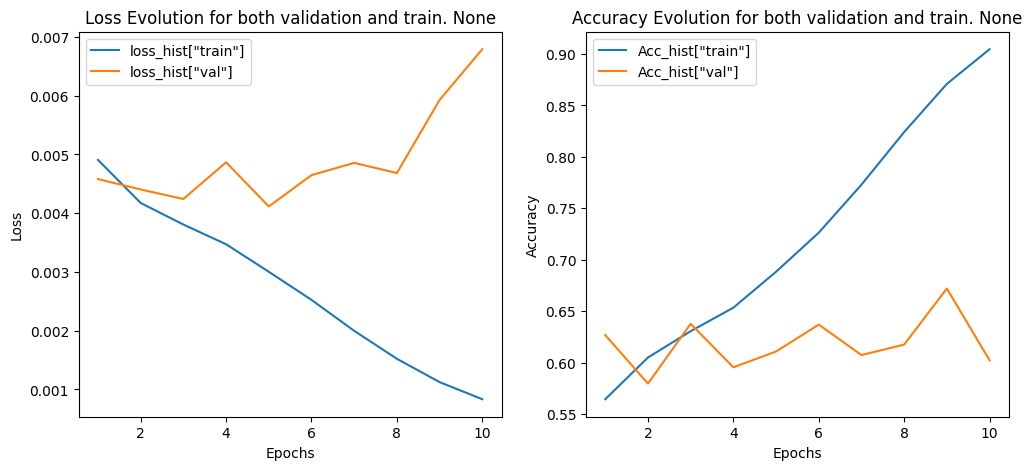

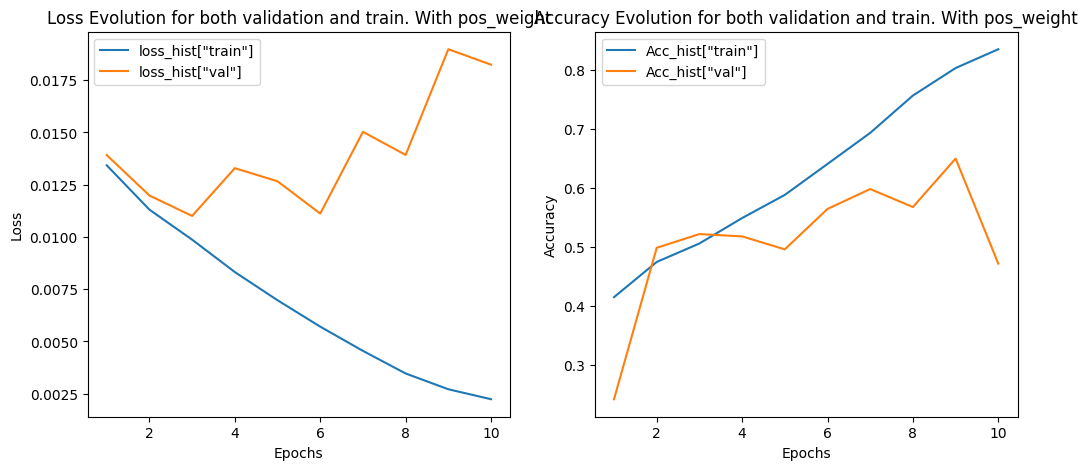

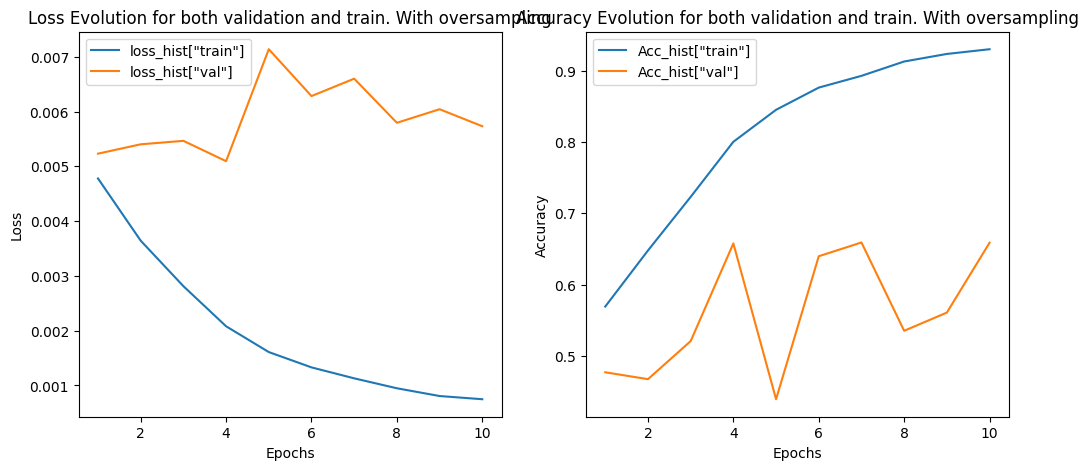

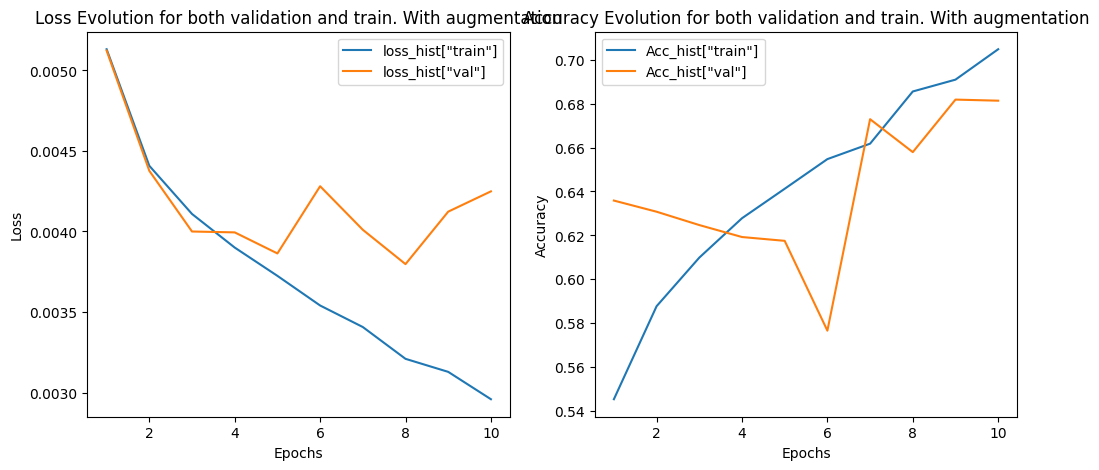

In [ ]:
k=5
import copy
import torchvision
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
from torchvision.models import resnet18, ResNet18_Weights,efficientnet_b4
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
kf = KFold(n_splits=k, shuffle=True, random_state=42)
metric_hist_list2 = []
loss_hist_list2 = []
resnet_model_list2 = []
best_model_wts_list2 = []

hamming_list3 = []
hamming_list4 = []

min_worst_f1_score2 = float('inf')
min_iteration = -1

max_best_f1_score2 = -float('inf')
max_iteration = -1



accuracy_list3 = []
precision_list3 = []
recall_list3 = []
f1_score_list3 = []

accuracy_list4 = []
precision_list4 = []
recall_list4 = []
f1_score_list4 = []


for index_val in range(4):
    cnn_model = resnet18(weights=None)

    num_ftrs = cnn_model.fc.in_features
    cnn_model.fc = nn.Linear(num_ftrs, 6)
    if torch.cuda.is_available():
        cnn_model.cuda()
    if torch.cuda.device_count() > 1:
        cnn_model = nn.DataParallel(cnn_model)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    cnn_model.to(device)
    X_train = df2.loc[train_min_index]
    X_val = df2.loc[val_min_index]
    files_with_train = X_train['Image'].to_list()
    files_with_val = X_val['Image'].to_list()
    files_train = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_train, hemDatTrain.file_location))
    files_val = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_val, hemDatTrain.file_location))


    df_Train = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_train['Image'].to_list())]
    df_Val = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_val['Image'].to_list())]
    df_Val = pd.concat([df_Val], ignore_index=True)
    df_Train = pd.concat([df_Train], ignore_index=True)

    df_Train = pd.concat([df_Train], ignore_index=True)

    hemDatTrain3 = None
    if index_val!=3:
    	hemDatTrain3 = HemorrhageDataset(files_train, df_Train, normal_transform, True, True)
    else:
    	hemDatTrain3 = HemorrhageDataset(files_train, df_Train, special_transform2, True, True)

    hemDatVal2 = HemorrhageDataset(files_val, df_Val, normal_transform, True, False)


    batch_size = 64

    num_weight = get_pos_weights(hemDatTrain3.df)
    sampler_pos_weight = get_sampler_pos_weight(hemDatTrain3.df, num_weight)
    num_weight = num_weight.to(device)
    sampler = WeightedRandomSampler(sampler_pos_weight, len(sampler_pos_weight))
    train_loader = None
    if index_val >=2:
         train_loader = torch.utils.data.DataLoader(hemDatTrain3, sampler=sampler, batch_size = batch_size, shuffle = False, num_workers=4, pin_memory=True)
    else:
         train_loader = torch.utils.data.DataLoader(hemDatTrain3, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(hemDatVal2, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(hemDatTest, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)

    val_shape = ()
    out_shape = ()
    for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
        for X, y in value:
            val_shape = X.shape
            out_shape = y.shape

            print(f"Shape of X : {X.shape}")
            print(f"{key}:")
            print(f"Shape of X : {X.shape}")
            print(f"Shape of y: {y.shape} {y.dtype}\n")
            break

    loss_function = torch.nn.BCEWithLogitsLoss()
    if index_val == 1:
       loss_function = torch.nn.BCEWithLogitsLoss(pos_weight = num_weight)
    params_train={
     "train": train_loader,"val": val_loader,
     "epochs": 10,
     "optimiser": optim.Adam(cnn_model.parameters(),lr=1e-4, weight_decay=1e-4),
     "lr_change": None,
     "f_loss": loss_function,
     "weight_path": "weights.pt",
    }

    resnet_model,loss_hist,metric_hist,best_model_wts = Train_Val(cnn_model,params_train, verbose=True)
    metric_hist_list2.append(metric_hist)
    loss_hist_list2.append(loss_hist)
    resnet_model_list2.append(resnet_model)
    best_model_wts_list2.append(best_model_wts)

    for idx, (train, val) in enumerate(zip(metric_hist['train'], metric_hist['val'])):
        print(f"Iteration {idx}. Accurracy for train :{train*100}. Accurracy for val :{val*100}")
    for idx, (train, val) in enumerate(zip(loss_hist['train'], loss_hist['val'])):
        print(f"Iteration {idx}. Loss for train :{train*100}. Loss for val :{val*100}")


    # Convergence History Plot
    epochs=params_train["epochs"]
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    list_metric_train = list(map(lambda x: x, metric_hist["train"]))
    list_metric_val = list(map(lambda x: x, metric_hist["val"]))

    string_name = "None"
    if index_val==1:
        string_name = "With pos_weight"
    elif index_val==2:
        string_name = "With oversampling"
    elif index_val==3:
        string_name = "With augmentation"

    sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
    sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')

    ax[0].set_title(f"Loss Evolution for both validation and train. {string_name}")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()


    sns.lineplot(x=[*range(1,epochs+1)],y=list_metric_train,ax=ax[1],label='Acc_hist["train"]')
    sns.lineplot(x=[*range(1,epochs+1)],y=list_metric_val,ax=ax[1],label='Acc_hist["val"]')
    ax[1].set_title(f"Accuracy Evolution for both validation and train. {string_name}")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    loss_func = torch.nn.BCEWithLogitsLoss()
    y_true, y_pred = Ture_and_Pred(test_loader, resnet_model, device)

    metric_b=accuracy_score(y_pred, y_true)
    _acc = metric_b
    _f1_score = f1_score(y_true, y_pred, average='macro')
    _recall = recall_score(y_true, y_pred, average='macro')
    _precision = precision_score(y_true, y_pred, average='macro')
    _hamming = hamming_loss(y_true, y_pred)
    accuracy_list3.append(_acc)
    precision_list3.append(_precision)
    recall_list3.append(_recall)
    f1_score_list3.append(_f1_score)
    hamming_list3.append(_hamming)




    print(f"For test:\n accuracy:{metric_b}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n hamming score:{1-_hamming}\n ")




    y_true, y_pred = Ture_and_Pred(val_loader, resnet_model, device)

    metric_b=accuracy_score(y_pred, y_true)
    _acc = metric_b
    _f1_score = f1_score(y_true, y_pred, average='macro')
    _recall = recall_score(y_true, y_pred, average='macro')
    _precision = precision_score(y_true, y_pred, average='macro')
    _hamming = hamming_loss(y_true, y_pred)
    accuracy_list4.append(_acc)
    precision_list4.append(_precision)
    recall_list4.append(_recall)
    f1_score_list4.append(_f1_score)
    hamming_list4.append(_hamming)



    print(f"For validation:\n accuracy:{metric_b}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n hamming score:{1-_hamming}\n ")

    if _f1_score < min_worst_f1_score2:
        min_worst_f1_score2 = _f1_score
        min_iteration = index_val



    if _f1_score > max_best_f1_score2:
        max_best_f1_score = _f1_score
        max_iteration = index_val





In [ ]:
import statistics
from prettytable import PrettyTable
table = PrettyTable(["Column","Accuracy Val", "F1-score Val", "Precision Val", "Recall Val", "Accuracy Test", "F1-score Test", "Precision Test", "Recall Test"])


for i in range(4):
    string_name = "None"
    if i==1:
        string_name = "With pos_weight"
    elif i==2:
        string_name = "With oversampling"
    elif i==3:
        string_name = "With augmentation"

    table.add_row([string_name, accuracy_list4[i], f1_score_list4[i], precision_list4[i], recall_list4[i], accuracy_list3[i], f1_score_list3[i], precision_list3[i], recall_list3[i]])
print(table)

+-------------------+--------------------+--------------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|       Column      |    Accuracy Val    |    F1-score Val    |    Precision Val    |     Recall Val     |    Accuracy Test    |   F1-score Test    |   Precision Test   |    Recall Test     |
+-------------------+--------------------+--------------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|        None       |  0.61082889356957  | 0.584309936737048  |  0.639293006156478  | 0.6104438357483671 | 0.27418811102371055 | 0.5598314433403141 | 0.6412954685804784 |  0.59989498974672  |
|  With pos_weight  | 0.5213728162557304 | 0.5697942737905569 | 0.48205283132008675 | 0.7678510713749688 | 0.12574446567030004 | 0.5664465618612561 | 0.5272214385080822 | 0.7716942536013347 |
| With oversampling | 0.6576632387560402

Normal transformation
Shape of X : torch.Size([64, 3, 224, 224])
Training data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32

Shape of X : torch.Size([64, 3, 224, 224])
Validation data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32

Shape of X : torch.Size([64, 3, 224, 224])
Test data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004730, dev loss: 0.005469, accuracy: 46.65
----------
Epoch 1/9, current lr=0.0001
train loss: 0.003759, dev loss: 0.008152, accuracy: 41.52
----------
Epoch 2/9, current lr=0.0001
train loss: 0.002902, dev loss: 0.006651, accuracy: 43.86
----------
Epoch 3/9, current lr=0.0001
train loss: 0.002150, dev loss: 0.006118, accuracy: 51.37
----------
Epoch 4/9, current lr=0.0001
train loss: 0.001698, dev loss: 0.005874, accuracy: 64.84
----------
Epoch 5/9, current lr=0.0001
train loss: 0.001333, dev loss: 0.005873, accuracy: 53.77
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001148, dev loss: 0.005713, accuracy: 55.99
----------
Epoch 7/9, current lr=0.0001
train loss: 0.000949, dev loss: 0.006297, accuracy: 52.51
----------
Epoch 8/9, current lr=0.0001
train loss: 0.000842, dev loss: 0.006535, accuracy: 67.14
----------
Epoch 9/9, current lr=0.0001
train loss: 0.000756, dev loss: 0.014226, accuracy: 27.13
----

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004817, dev loss: 0.008775, accuracy: 24.64
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.003844, dev loss: 0.004412, accuracy: 63.72
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.003020, dev loss: 0.004363, accuracy: 63.97
----------
Epoch 3/9, current lr=0.0001
train loss: 0.002322, dev loss: 0.006199, accuracy: 66.25
----------
Epoch 4/9, current lr=0.0001
train loss: 0.001809, dev loss: 0.009649, accuracy: 33.14
----------
Epoch 5/9, current lr=0.0001
train loss: 0.001448, dev loss: 0.005259, accuracy: 64.03
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001213, dev loss: 0.005925, accuracy: 56.92
----------
Epoch 7/9, current lr=0.0001
train loss: 0.001029, dev loss: 0.005707, accuracy: 55.72
----------
Epoch 8/9, current lr=0.0001
train loss: 0.000895, dev loss: 0.006604, accuracy: 64.45
----------
Epoch 9/9, current lr=0.0001
train lo

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004680, dev loss: 0.004580, accuracy: 56.33
----------
Epoch 1/9, current lr=0.0001
train loss: 0.003657, dev loss: 0.006725, accuracy: 40.40
----------
Epoch 2/9, current lr=0.0001
train loss: 0.002858, dev loss: 0.006667, accuracy: 64.79
----------
Epoch 3/9, current lr=0.0001
train loss: 0.002169, dev loss: 0.006331, accuracy: 65.90
----------
Epoch 4/9, current lr=0.0001
train loss: 0.001748, dev loss: 0.006608, accuracy: 65.28
----------
Epoch 5/9, current lr=0.0001
train loss: 0.001350, dev loss: 0.007365, accuracy: 46.56
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001151, dev loss: 0.006952, accuracy: 51.00
----------
Epoch 7/9, current lr=0.0001
train loss: 0.000948, dev loss: 0.006979, accuracy: 49.97
----------
Epoch 8/9, current lr=0.0001
train loss: 0.000867, dev loss: 0.007866, accuracy: 52.93
----------
Epoch 9/9, current lr=0.0001
train loss: 0.000755, dev loss: 0.005757, accuracy: 63.54
----

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004731, dev loss: 0.005700, accuracy: 38.98
----------
Epoch 1/9, current lr=0.0001
train loss: 0.003513, dev loss: 0.005798, accuracy: 49.57
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.002641, dev loss: 0.005137, accuracy: 60.36
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.001994, dev loss: 0.005008, accuracy: 65.37
----------
Epoch 4/9, current lr=0.0001
train loss: 0.001537, dev loss: 0.005717, accuracy: 65.71
----------
Epoch 5/9, current lr=0.0001
train loss: 0.001250, dev loss: 0.005335, accuracy: 61.02
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001103, dev loss: 0.006133, accuracy: 66.85
----------
Epoch 7/9, current lr=0.0001
train loss: 0.000921, dev loss: 0.006092, accuracy: 64.93
----------
Epoch 8/9, current lr=0.0001
train loss: 0.000831, dev loss: 0.005511, accuracy: 61.54
----------
Epoch 9/9, current lr=0.0001
train lo

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.004811, dev loss: 0.004553, accuracy: 58.02
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.003711, dev loss: 0.004459, accuracy: 60.99
----------
Epoch 2/9, current lr=0.0001
train loss: 0.002840, dev loss: 0.005245, accuracy: 64.72
----------
Epoch 3/9, current lr=0.0001
train loss: 0.002195, dev loss: 0.005023, accuracy: 59.12
----------
Epoch 4/9, current lr=0.0001
train loss: 0.001710, dev loss: 0.009124, accuracy: 36.02
----------
Epoch 5/9, current lr=0.0001
train loss: 0.001351, dev loss: 0.004905, accuracy: 64.61
----------
Epoch 6/9, current lr=0.0001
train loss: 0.001157, dev loss: 0.004948, accuracy: 63.54
----------
Epoch 7/9, current lr=0.0001
train loss: 0.000968, dev loss: 0.005248, accuracy: 64.80
----------
Epoch 8/9, current lr=0.0001
train loss: 0.000872, dev loss: 0.006031, accuracy: 58.25
----------
Epoch 9/9, current lr=0.0001
train loss: 0.000743, dev loss: 0.0

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005099, dev loss: 0.004739, accuracy: 57.44
----------
Epoch 1/9, current lr=0.0001
train loss: 0.004438, dev loss: 0.005936, accuracy: 63.75
----------
Epoch 2/9, current lr=0.0001
train loss: 0.004118, dev loss: 0.005292, accuracy: 42.24
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.003876, dev loss: 0.004226, accuracy: 65.39
----------
Epoch 4/9, current lr=0.0001
train loss: 0.003697, dev loss: 0.004663, accuracy: 56.78
----------
Epoch 5/9, current lr=0.0001
Copied best model weights!
train loss: 0.003491, dev loss: 0.004151, accuracy: 59.32
----------
Epoch 6/9, current lr=0.0001
Copied best model weights!
train loss: 0.003361, dev loss: 0.003724, accuracy: 66.63
----------
Epoch 7/9, current lr=0.0001
train loss: 0.003225, dev loss: 0.004089, accuracy: 65.80
----------
Epoch 8/9, current lr=0.0001
train loss: 0.003032, dev loss: 0.004898, accuracy: 67.54
----------
Epoch 9/9,

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005124, dev loss: 0.004565, accuracy: 57.50
----------
Epoch 1/9, current lr=0.0001
train loss: 0.004344, dev loss: 0.005200, accuracy: 47.33
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.004040, dev loss: 0.004257, accuracy: 59.40
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.003827, dev loss: 0.004108, accuracy: 57.18
----------
Epoch 4/9, current lr=0.0001
train loss: 0.003688, dev loss: 0.004558, accuracy: 63.64
----------
Epoch 5/9, current lr=0.0001
Copied best model weights!
train loss: 0.003548, dev loss: 0.004073, accuracy: 66.68
----------
Epoch 6/9, current lr=0.0001
train loss: 0.003324, dev loss: 0.005084, accuracy: 67.67
----------
Epoch 7/9, current lr=0.0001
Copied best model weights!
train loss: 0.003208, dev loss: 0.003872, accuracy: 62.56
----------
Epoch 8/9, current lr=0.0001
train loss: 0.003075, dev loss: 0.003987, accuracy: 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005095, dev loss: 0.004569, accuracy: 54.66
----------
Epoch 1/9, current lr=0.0001
train loss: 0.004372, dev loss: 0.005024, accuracy: 50.48
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.004096, dev loss: 0.004541, accuracy: 65.35
----------
Epoch 3/9, current lr=0.0001
train loss: 0.003820, dev loss: 0.004671, accuracy: 66.34
----------
Epoch 4/9, current lr=0.0001
Copied best model weights!
train loss: 0.003675, dev loss: 0.004092, accuracy: 67.17
----------
Epoch 5/9, current lr=0.0001
train loss: 0.003488, dev loss: 0.004113, accuracy: 59.01
----------
Epoch 6/9, current lr=0.0001
Copied best model weights!
train loss: 0.003362, dev loss: 0.003725, accuracy: 66.45
----------
Epoch 7/9, current lr=0.0001
train loss: 0.003203, dev loss: 0.003838, accuracy: 64.84
----------
Epoch 8/9, current lr=0.0001
train loss: 0.003040, dev loss: 0.003787, accuracy: 65.16
----------
Epoch 9/9,

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005184, dev loss: 0.004910, accuracy: 63.11
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.004434, dev loss: 0.004533, accuracy: 58.72
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.004218, dev loss: 0.004215, accuracy: 60.35
----------
Epoch 3/9, current lr=0.0001
train loss: 0.003929, dev loss: 0.004312, accuracy: 65.24
----------
Epoch 4/9, current lr=0.0001
Copied best model weights!
train loss: 0.003694, dev loss: 0.004088, accuracy: 65.70
----------
Epoch 5/9, current lr=0.0001
train loss: 0.003560, dev loss: 0.004444, accuracy: 57.19
----------
Epoch 6/9, current lr=0.0001
train loss: 0.003389, dev loss: 0.005288, accuracy: 58.66
----------
Epoch 7/9, current lr=0.0001
Copied best model weights!
train loss: 0.003272, dev loss: 0.003774, accuracy: 66.38
----------
Epoch 8/9, current lr=0.0001
train loss: 0.003167, dev loss: 0.003924, accuracy: 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005143, dev loss: 0.005550, accuracy: 40.14
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.004399, dev loss: 0.004402, accuracy: 63.92
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.004090, dev loss: 0.004192, accuracy: 64.58
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.003856, dev loss: 0.004001, accuracy: 60.90
----------
Epoch 4/9, current lr=0.0001
Copied best model weights!
train loss: 0.003640, dev loss: 0.003835, accuracy: 64.61
----------
Epoch 5/9, current lr=0.0001
train loss: 0.003447, dev loss: 0.003928, accuracy: 66.51
----------
Epoch 6/9, current lr=0.0001
train loss: 0.003341, dev loss: 0.004072, accuracy: 67.36
----------
Epoch 7/9, current lr=0.0001
train loss: 0.003177, dev loss: 0.003866, accuracy: 67.40
----------
Epoch 8/9, current lr=0.0001
train loss: 0.003067, dev loss: 0.004329, accuracy: 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005308, dev loss: 0.006320, accuracy: 34.85
----------
Epoch 1/9, current lr=0.0001
train loss: 0.004607, dev loss: 0.008773, accuracy: 25.28
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.004276, dev loss: 0.005577, accuracy: 56.80
----------
Epoch 3/9, current lr=0.0001
Copied best model weights!
train loss: 0.004065, dev loss: 0.004037, accuracy: 61.95
----------
Epoch 4/9, current lr=0.0001
train loss: 0.003901, dev loss: 0.004155, accuracy: 61.03
----------
Epoch 5/9, current lr=0.0001
train loss: 0.003735, dev loss: 0.004176, accuracy: 67.74
----------
Epoch 6/9, current lr=0.0001
train loss: 0.003548, dev loss: 0.005180, accuracy: 44.65
----------
Epoch 7/9, current lr=0.0001
train loss: 0.003480, dev loss: 0.005337, accuracy: 44.78
----------
Epoch 8/9, current lr=0.0001
Copied best model weights!
train loss: 0.003367, dev loss: 0.003849, accuracy: 61.57
----------
Epoch 9/9,

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005291, dev loss: 0.004758, accuracy: 60.24
----------
Epoch 1/9, current lr=0.0001
train loss: 0.004565, dev loss: 0.005155, accuracy: 50.63
----------
Epoch 2/9, current lr=0.0001
train loss: 0.004293, dev loss: 0.005162, accuracy: 65.43
----------
Epoch 3/9, current lr=0.0001
train loss: 0.004043, dev loss: 0.004927, accuracy: 45.62
----------
Epoch 4/9, current lr=0.0001
Copied best model weights!
train loss: 0.003862, dev loss: 0.004084, accuracy: 60.60
----------
Epoch 5/9, current lr=0.0001
Copied best model weights!
train loss: 0.003775, dev loss: 0.003834, accuracy: 66.11
----------
Epoch 6/9, current lr=0.0001
train loss: 0.003542, dev loss: 0.003911, accuracy: 66.55
----------
Epoch 7/9, current lr=0.0001
train loss: 0.003463, dev loss: 0.004098, accuracy: 60.77
----------
Epoch 8/9, current lr=0.0001
train loss: 0.003322, dev loss: 0.004104, accuracy: 66.10
----------
Epoch 9/9, current lr=0.0001
train lo

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005259, dev loss: 0.005868, accuracy: 63.49
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.004557, dev loss: 0.004272, accuracy: 59.89
----------
Epoch 2/9, current lr=0.0001
train loss: 0.004259, dev loss: 0.004608, accuracy: 58.13
----------
Epoch 3/9, current lr=0.0001
train loss: 0.004121, dev loss: 0.005038, accuracy: 66.10
----------
Epoch 4/9, current lr=0.0001
Copied best model weights!
train loss: 0.003834, dev loss: 0.004065, accuracy: 56.04
----------
Epoch 5/9, current lr=0.0001
train loss: 0.003696, dev loss: 0.004148, accuracy: 57.54
----------
Epoch 6/9, current lr=0.0001
Copied best model weights!
train loss: 0.003598, dev loss: 0.003694, accuracy: 64.86
----------
Epoch 7/9, current lr=0.0001
train loss: 0.003503, dev loss: 0.004342, accuracy: 60.98
----------
Epoch 8/9, current lr=0.0001
Copied best model weights!
train loss: 0.003404, dev loss: 0.003591, accuracy: 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005274, dev loss: 0.007168, accuracy: 64.30
----------
Epoch 1/9, current lr=0.0001
Copied best model weights!
train loss: 0.004626, dev loss: 0.004509, accuracy: 63.61
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.004341, dev loss: 0.004463, accuracy: 64.98
----------
Epoch 3/9, current lr=0.0001
train loss: 0.004123, dev loss: 0.004782, accuracy: 54.24
----------
Epoch 4/9, current lr=0.0001
Copied best model weights!
train loss: 0.003916, dev loss: 0.004359, accuracy: 56.93
----------
Epoch 5/9, current lr=0.0001
train loss: 0.003736, dev loss: 0.004486, accuracy: 58.38
----------
Epoch 6/9, current lr=0.0001
train loss: 0.003591, dev loss: 0.004454, accuracy: 54.50
----------
Epoch 7/9, current lr=0.0001
train loss: 0.003512, dev loss: 0.004416, accuracy: 64.04
----------
Epoch 8/9, current lr=0.0001
train loss: 0.003356, dev loss: 0.004753, accuracy: 50.92
----------
Epoch 9/9,

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.0001
Copied best model weights!
train loss: 0.005213, dev loss: 0.004766, accuracy: 61.75
----------
Epoch 1/9, current lr=0.0001
train loss: 0.004599, dev loss: 0.005679, accuracy: 63.16
----------
Epoch 2/9, current lr=0.0001
Copied best model weights!
train loss: 0.004263, dev loss: 0.004135, accuracy: 62.87
----------
Epoch 3/9, current lr=0.0001
train loss: 0.004122, dev loss: 0.004775, accuracy: 64.73
----------
Epoch 4/9, current lr=0.0001
train loss: 0.003878, dev loss: 0.006565, accuracy: 32.76
----------
Epoch 5/9, current lr=0.0001
Copied best model weights!
train loss: 0.003743, dev loss: 0.003972, accuracy: 63.09
----------
Epoch 6/9, current lr=0.0001
train loss: 0.003570, dev loss: 0.005461, accuracy: 54.56
----------
Epoch 7/9, current lr=0.0001
Copied best model weights!
train loss: 0.003450, dev loss: 0.003713, accuracy: 66.34
----------
Epoch 8/9, current lr=0.0001
train loss: 0.003348, dev loss: 0.003788, accuracy: 66.42
----------
Epoch 9/9,

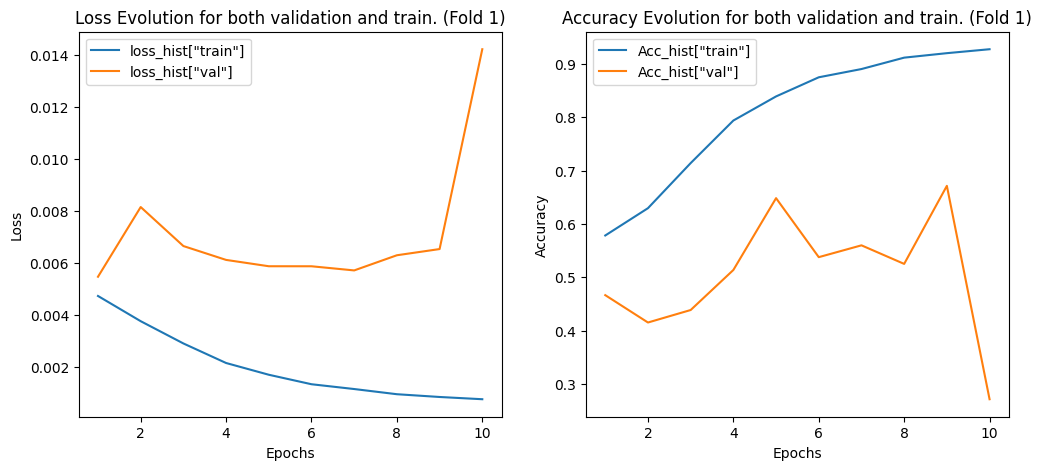

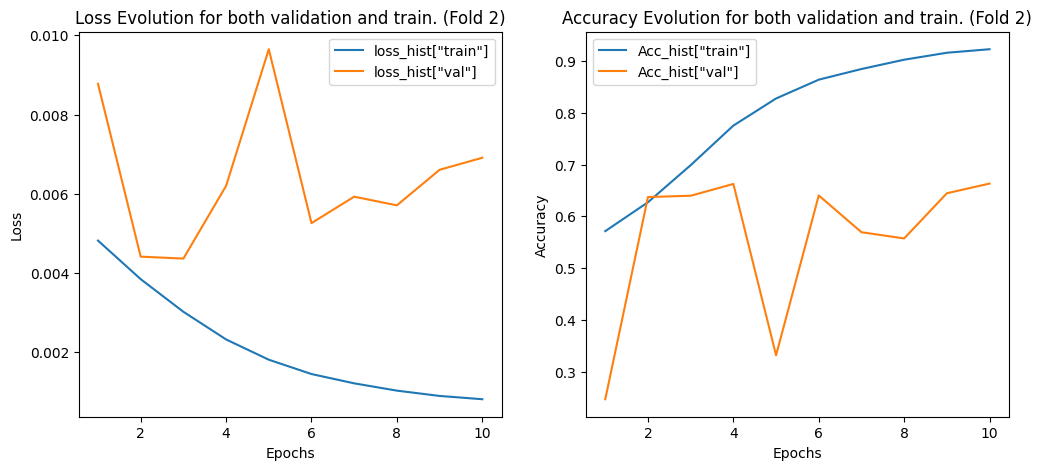

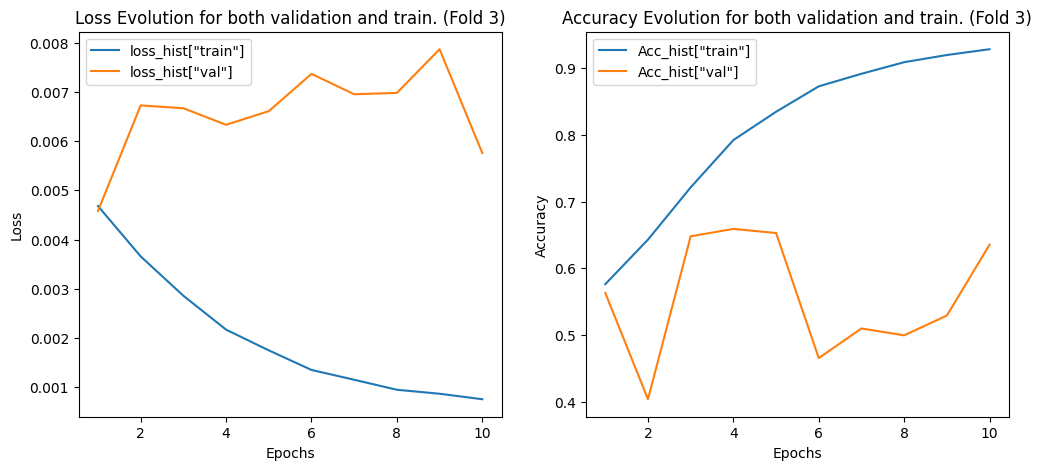

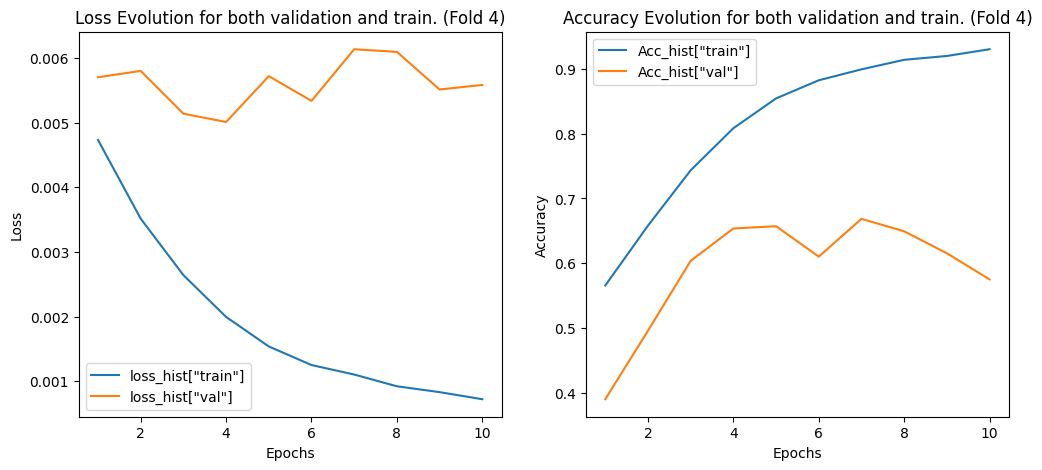

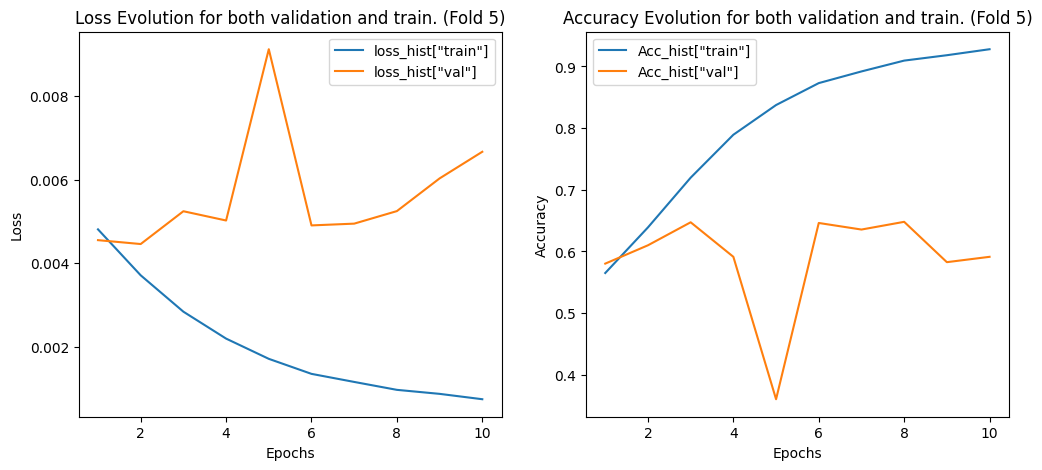

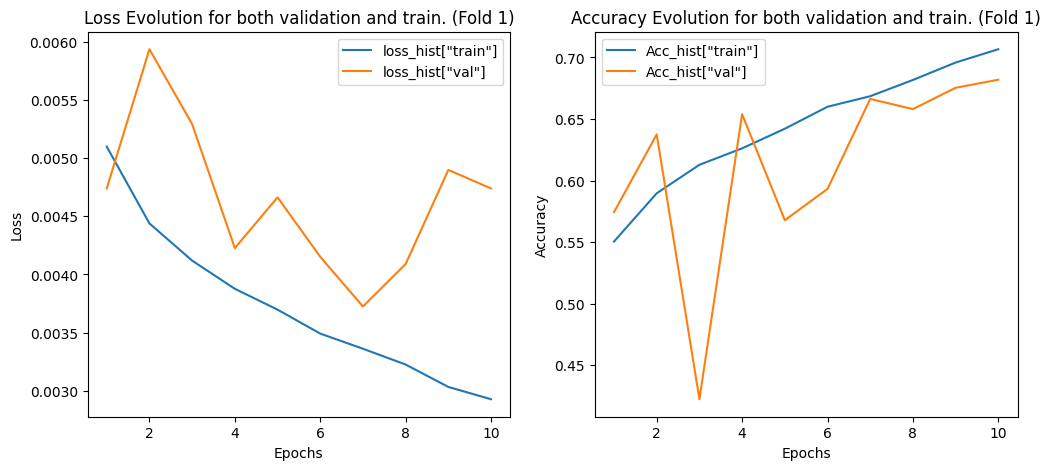

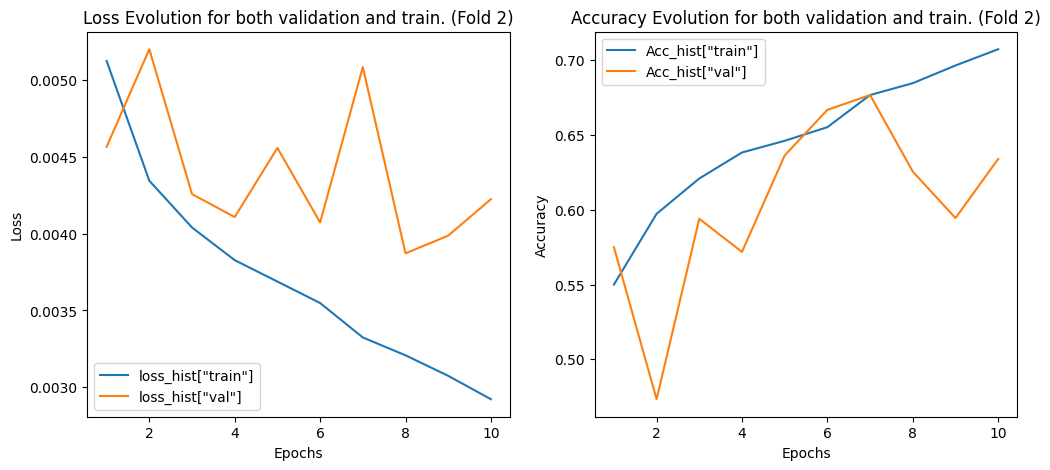

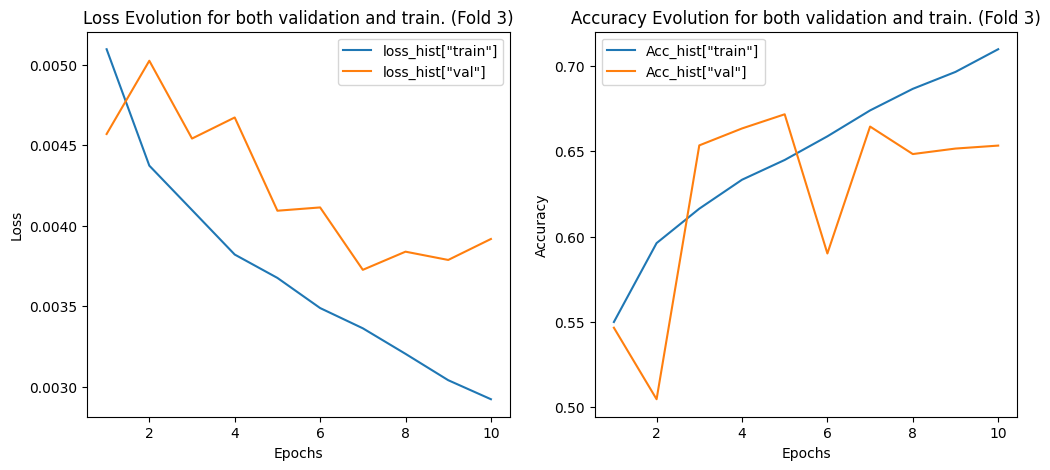

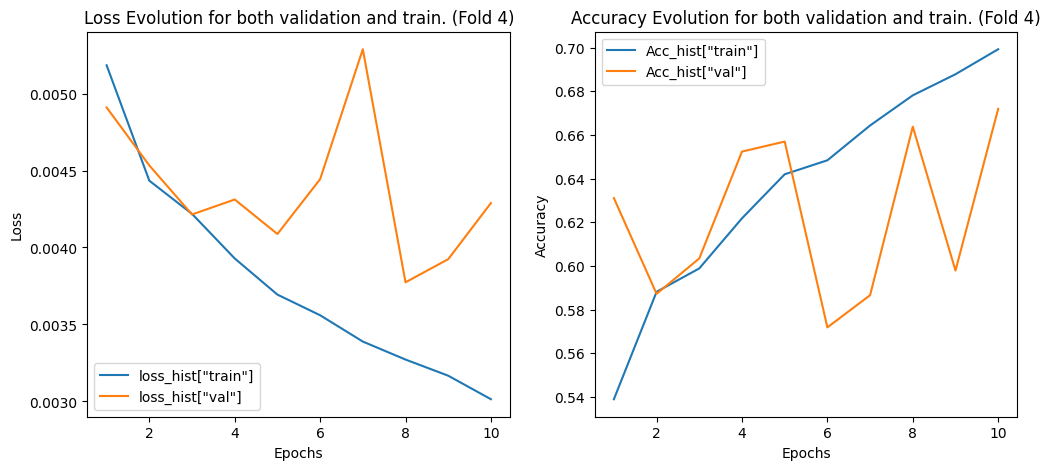

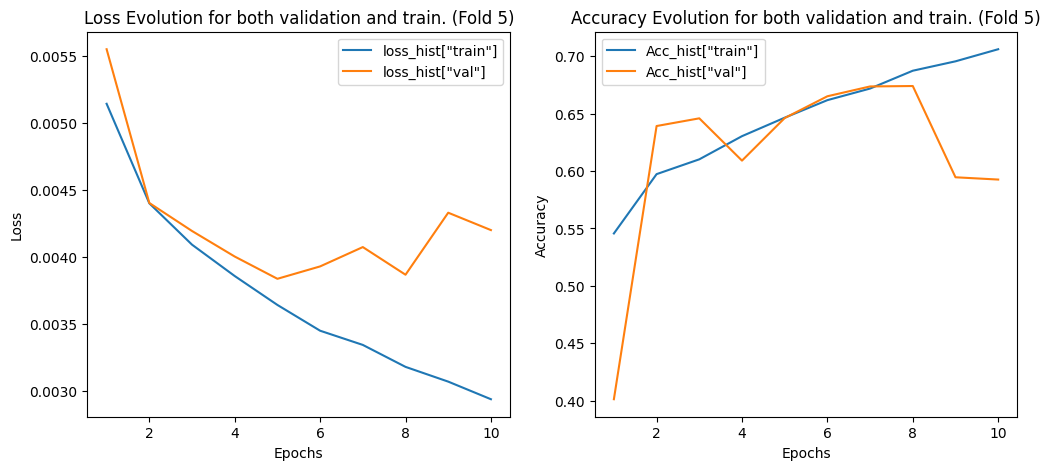

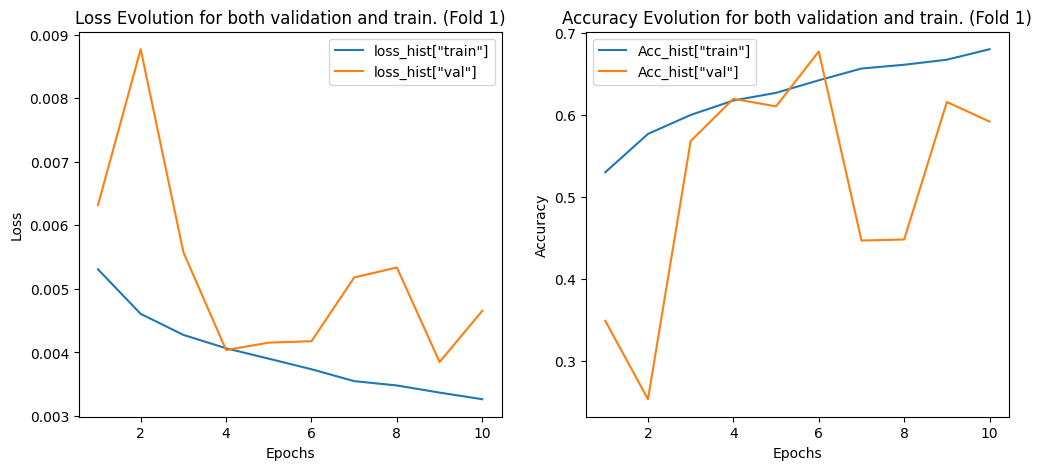

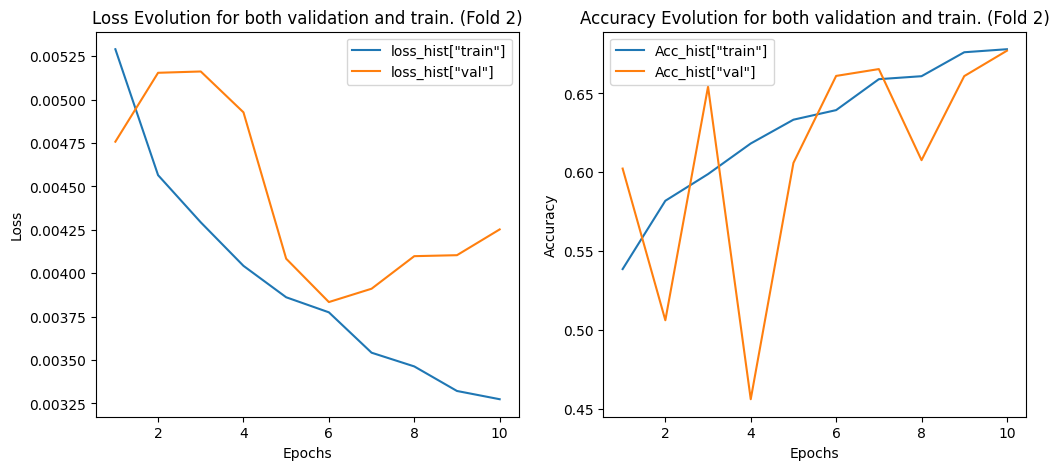

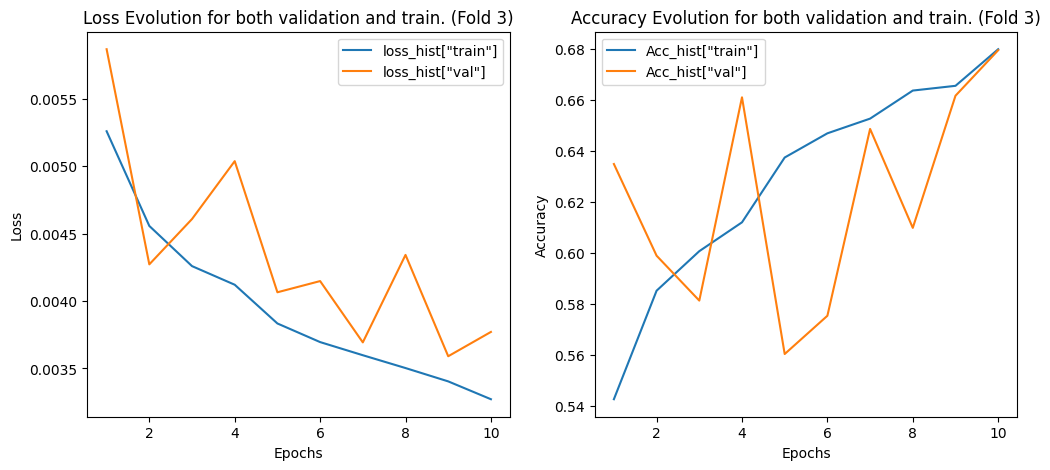

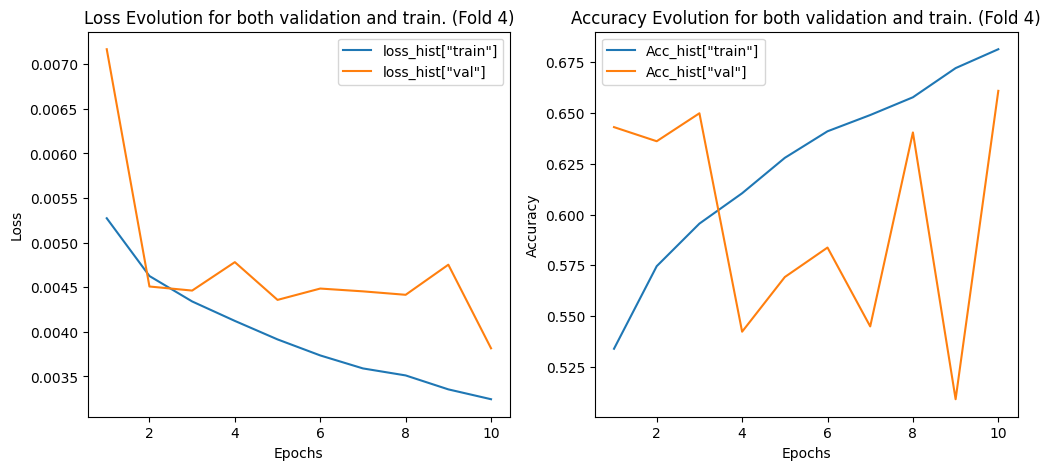

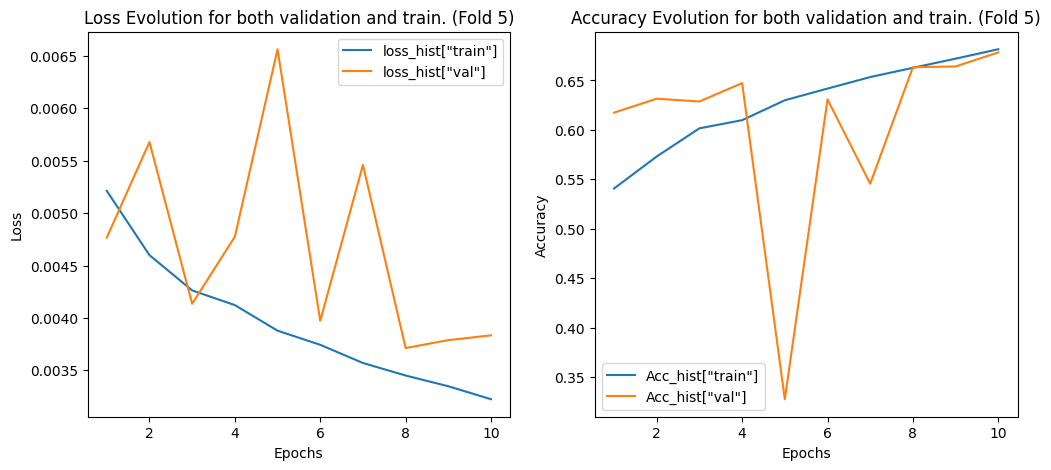

In [ ]:
k = 5  # Number of folds
import copy
import torchvision
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
from torchvision.models import resnet18, ResNet18_Weights,efficientnet_b4
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score,  roc_auc_score, accuracy_score
import statistics
import statistics
from prettytable import PrettyTable

kf = KFold(n_splits=k, shuffle=True, random_state=42)

metric_hist_list = []
loss_hist_list = []
resnet_model_list = []
best_model_wts_list = []


min_worst_f1_score = float('inf')
val_min_index = []
train_min_index = []

max_best_f1_score = -float('inf')
val_max_index = []
train_max_index = []
max_fold = -1

val_index2 = []
min_fold = -1


val_loss = []
val_acc = []
train_loss = []
train_acc = []
max_index_transformation=-1
min_index_transformation=-1

special_transformation2 = normal_transform

mean_precision_list = []
mean_recall_list = []
mean_f1_score_list = []
mean_auc_score_list = []
mean_accuracy_score_list = []


mean_precision_list2 = []
mean_recall_list2 = []
mean_f1_score_list2 = []
mean_auc_score_list2 = []
mean_accuracy_score_list2 = []
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
for index_it in range(3):
    precision_list = []
    recall_list = []
    f1_score_list = []
    auc_score_list = []
    accuracy_score_list = []


    precision_list2 = []
    recall_list2 = []
    f1_score_list2 = []
    auc_score_list2 = []
    accuracy_score_list2 = []


    if (index_it == 0):
        print("Normal transformation")
        special_transformation2  = normal_transform
    elif (index_it == 1):
        print("Moderate augmentation")
        special_transformation2 = special_transform2
    else:
        print("Aggresive augmentation")
        special_transformation2 = special_transform


    for fold, (train_index, val_index) in enumerate(kf.split(df2)):
        cnn_model = resnet18(weights=None)

        num_ftrs = cnn_model.fc.in_features
        cnn_model.fc = nn.Linear(num_ftrs, 6)
        if torch.cuda.is_available():
            cnn_model.cuda()
        if torch.cuda.device_count() > 1:
            cnn_model = nn.DataParallel(cnn_model)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        cnn_model.to(device)

        X_train = df2.loc[train_index]
        X_val = df2.loc[val_index]
        files_with_train = X_train['Image'].to_list()
        files_with_val = X_val['Image'].to_list()
        files_train = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_train, hemDatTrain.file_location))
        files_val = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_val, hemDatTrain.file_location))
        df_Train = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_train['Image'].to_list())]
        df_Val = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_val['Image'].to_list())]
        df_Val = pd.concat([df_Val], ignore_index=True)

        df_Train = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_train['Image'].to_list())]
        df_Val = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_val['Image'].to_list())]
        df_Val = pd.concat([df_Val], ignore_index=True)
        df_Train = pd.concat([df_Train], ignore_index=True)

        hemDatTrain3 = HemorrhageDataset(files_train, df_Train, special_transformation2, True, True)
        hemDatVal2 = HemorrhageDataset(files_val, df_Val, normal_transform, True, False)


        batch_size = 64

        num_weight = get_pos_weights(hemDatTrain3.df)
        sampler_pos_weight = get_sampler_pos_weight(hemDatTrain3.df, num_weight)
        num_weight = num_weight.to(device)
        sampler = WeightedRandomSampler(sampler_pos_weight, len(sampler_pos_weight))
        train_loader = None
        train_loader = torch.utils.data.DataLoader(hemDatTrain3, sampler=sampler, batch_size = batch_size, shuffle = False, num_workers=4, pin_memory=True)

        val_loader = torch.utils.data.DataLoader(hemDatVal2, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
        test_loader = torch.utils.data.DataLoader(hemDatTest, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)






        val_shape = ()
        out_shape = ()
        for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
            for X, y in value:
                val_shape = X.shape
                out_shape = y.shape

                print(f"Shape of X : {X.shape}")
                print(f"{key}:")
                print(f"Shape of X : {X.shape}")
                print(f"Shape of y: {y.shape} {y.dtype}\n")
                break


        params_train={
         "train": train_loader,"val": val_loader,
         "epochs": 10,
         "optimiser": optim.Adam(cnn_model.parameters(),lr=1e-4, weight_decay=1e-4),
         "lr_change": None,
         "f_loss": torch.nn.BCEWithLogitsLoss(),
         "weight_path": "weights.pt",
        }

        resnet_model,loss_hist,metric_hist,best_model_wts = Train_Val(cnn_model,params_train, verbose=True)
        metric_hist_list.append(metric_hist)
        loss_hist_list.append(loss_hist)
        resnet_model_list.append(resnet_model)
        best_model_wts_list.append(best_model_wts)

        for idx, (train, val) in enumerate(zip(metric_hist['train'], metric_hist['val'])):
            print(f"Iteration {idx}. Accurracy for train :{train*100}. Accurracy for val :{val*100}")
        for idx, (train, val) in enumerate(zip(loss_hist['train'], loss_hist['val'])):
            print(f"Iteration {idx}. Loss for train :{train}. Loss for val :{val}")

        # Convergence History Plot
        epochs=params_train["epochs"]
        fig,ax = plt.subplots(1,2,figsize=(12,5))
        list_metric_train = list(map(lambda x: x, metric_hist["train"]))
        list_metric_val = list(map(lambda x: x, metric_hist["val"]))

        sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
        sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')

        ax[0].set_title(f"Loss Evolution for both validation and train. (Fold {fold+1})")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        sns.lineplot(x=[*range(1,epochs+1)],y=list_metric_train,ax=ax[1],label='Acc_hist["train"]')
        sns.lineplot(x=[*range(1,epochs+1)],y=list_metric_val,ax=ax[1],label='Acc_hist["val"]')
        ax[1].set_title(f"Accuracy Evolution for both validation and train. (Fold {fold+1})")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend()
        loss_func = torch.nn.BCEWithLogitsLoss()
        y_true, y_pred = Ture_and_Pred(test_loader, resnet_model, device)

        auc_score=roc_auc_score(y_pred, y_true, multi_class='ovr',average='macro')
        _f1_score = f1_score(y_true, y_pred, average='macro')
        _recall = recall_score(y_true, y_pred, average='macro')
        _precision = precision_score(y_true, y_pred, average='macro')
        auc_score_list.append(auc_score)
        precision_list.append(_precision)
        recall_list.append(_recall)
        f1_score_list.append(_f1_score)
        accuracy_s = accuracy_score(y_pred, y_true)
        accuracy_score_list.append(accuracy_s)
        print(f"For test:\n auc:{auc_score}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n ")


        y_true, y_pred = Ture_and_Pred(val_loader, resnet_model, device)

        auc_score=roc_auc_score(y_pred, y_true, multi_class='ovr',average='macro')
        _f1_score = f1_score(y_true, y_pred, average='macro')
        _recall = recall_score(y_true, y_pred, average='macro')
        _precision = precision_score(y_true, y_pred, average='macro')
        auc_score_list2.append(auc_score)
        precision_list2.append(_precision)
        recall_list2.append(_recall)
        f1_score_list2.append(_f1_score)
        accuracy_s2 = accuracy_score(y_pred, y_true)
        accuracy_score_list2.append(accuracy_s2)
        print(f"For validation:\n auc:{auc_score}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n ")




    table = PrettyTable(["Column","AUC Test", "Accuracy Test", "F1-score Test", "Precision Test", "Recall Test"])


    for i in range(5):
        table.add_row([f"Fold {i} Test", auc_score_list[i], accuracy_score_list[i], f1_score_list[i], precision_list[i], recall_list[i]])
        table.add_row([f"Fold {i} Validation", auc_score_list2[i], accuracy_score_list2[i], f1_score_list2[i], precision_list2[i], recall_list2[i]])

    print(table)

    mean_precision_list.append(statistics.mean(precision_list))
    mean_recall_list.append(statistics.mean(recall_list))
    mean_f1_score_list.append(statistics.mean(f1_score_list))
    mean_accuracy_score_list.append(statistics.mean(accuracy_score_list))
    mean_auc_score_list.append(statistics.mean(auc_score_list))



    mean_precision_list2.append(statistics.mean(precision_list2))
    mean_recall_list2.append(statistics.mean(recall_list2))
    mean_f1_score_list2.append(statistics.mean(f1_score_list2))
    mean_accuracy_score_list.append(statistics.mean(accuracy_score_list2))

    mean_auc_score_list2.append(statistics.mean(auc_score_list2))





In [6]:
import statistics
from prettytable import PrettyTable
table = PrettyTable(["Column","AUC", "Accuracy", "F1-score", "Precision", "Recall"])

for i in range(3):
    str_column = ""
    if i==0:
        str_column = "Normal transformation"
    elif i==1:
        str_column = "Moderate augmentation"
    else:
        str_column = "Aggresive augmentation"
    table.add_row([str_column, mean_auc_score_list[i], mean_accuracy_score_list[i], mean_f1_score_list[i], mean_precision_list[i],mean_recall_list[i]])
print(table)

+------------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|         Column         |        AUC         |       Accuracy      |      F1-score      |     Precision      |       Recall       |
+------------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
| Normal transformation  | 0.6600242298035052 |  0.224070120238229  | 0.5104473497307321 | 0.670668224366482  | 0.4624486049402585 |
| Moderate augmentation  | 0.7045321986497357 | 0.26677154736487246 | 0.5386574435290717 | 0.6859191175809999 | 0.500448694999668  |
| Aggresive augmentation | 0.7035752640649859 |  0.2825036520957411 | 0.5641806612925477 | 0.6703457116517098 | 0.524745230442138  |
+------------------------+--------------------+---------------------+--------------------+--------------------+--------------------+


Mergem in continuare cu moderate augmentation, asa ca ne uitam pe tabelul al doilea, dar pentru fiecare metrica un fold poate fi mai slab din pct de vedere metricilor de validare, dar analizand pe de parte, fold 1 e cel mai prost, luand in considerare ca la cerinta 1 am avut rezultatele cele mai slabe acolo

In [ ]:

min_fold = 1

for fold, (train_index, val_index) in enumerate(kf.split(df2)):
    if fold==min_fold:
        train_min_index = train_index
        val_min_index = val_index
        break


Shape of X : torch.Size([64, 3, 224, 224])
Training data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32

Shape of X : torch.Size([64, 3, 224, 224])
Validation data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32

Shape of X : torch.Size([64, 3, 224, 224])
Test data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 6]) torch.float32



  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0/11, current lr=0.0001
Copied best model weights!
train loss: 0.005129, dev loss: 0.005683, accuracy: 46.45
----------
Epoch 1/11, current lr=0.0001
Copied best model weights!
train loss: 0.004392, dev loss: 0.004659, accuracy: 63.11
----------
Epoch 2/11, current lr=0.0001
Copied best model weights!
train loss: 0.004083, dev loss: 0.004471, accuracy: 64.99
----------
Epoch 3/11, current lr=0.0001
train loss: 0.003781, dev loss: 0.004720, accuracy: 57.13
----------
Epoch 4/11, current lr=0.0001
Copied best model weights!
train loss: 0.003692, dev loss: 0.004407, accuracy: 58.02
----------
Epoch 5/11, current lr=0.0001
Copied best model weights!
train loss: 0.003573, dev loss: 0.003941, accuracy: 62.02
----------
Epoch 6/11, current lr=0.0001
train loss: 0.003423, dev loss: 0.004069, accuracy: 59.27
----------
Epoch 7/11, current lr=0.0001
train loss: 0.003241, dev loss: 0.004512, accuracy: 67.38
----------
Epoch 8/11, current lr=0.0001
train loss: 0.003127, dev loss: 0.004982, a

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0/11, current lr=0.0001
Copied best model weights!
train loss: 0.005059, dev loss: 0.005779, accuracy: 49.00
----------
Epoch 1/11, current lr=0.0001


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Copied best model weights!
train loss: 0.004379, dev loss: 0.004367, accuracy: 56.57
----------
Epoch 2/11, current lr=0.0001
train loss: 0.004036, dev loss: 0.004832, accuracy: 65.61
----------
Epoch 3/11, current lr=0.0001
Copied best model weights!
train loss: 0.003804, dev loss: 0.004056, accuracy: 61.93
----------
Epoch 4/11, current lr=0.0001
train loss: 0.003640, dev loss: 0.004192, accuracy: 56.37
----------
Epoch 5/11, current lr=0.0001
train loss: 0.003484, dev loss: 0.004971, accuracy: 48.56
----------
Epoch 6/11, current lr=0.0001
train loss: 0.003311, dev loss: 0.004796, accuracy: 47.24
----------
Epoch 7/11, current lr=0.0001
Copied best model weights!
train loss: 0.003190, dev loss: 0.003755, accuracy: 66.31
----------
Epoch 8/11, current lr=0.0001
train loss: 0.003068, dev loss: 0.004335, accuracy: 67.54
----------
Epoch 9/11, current lr=0.0001
train loss: 0.002914, dev loss: 0.005050, accuracy: 50.89
----------
Epoch 10/11, current lr=0.0001
train loss: 0.002797, dev l

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0/11, current lr=0.0001
Copied best model weights!
train loss: 0.005138, dev loss: 0.005190, accuracy: 50.06
----------
Epoch 1/11, current lr=0.0001
Copied best model weights!
train loss: 0.004398, dev loss: 0.004875, accuracy: 60.35
----------
Epoch 2/11, current lr=0.0001
Copied best model weights!
train loss: 0.004104, dev loss: 0.004251, accuracy: 61.06
----------
Epoch 3/11, current lr=0.0001
Copied best model weights!
train loss: 0.003827, dev loss: 0.003937, accuracy: 64.60
----------
Epoch 4/11, current lr=0.0001
train loss: 0.003632, dev loss: 0.006315, accuracy: 33.44
----------
Epoch 5/11, current lr=0.0001
train loss: 0.003522, dev loss: 0.005131, accuracy: 66.84
----------
Epoch 6/11, current lr=0.0001
Loading best model weights!
train loss: 0.003359, dev loss: 0.005139, accuracy: 48.84
----------
Epoch 7/11, current lr=5e-05
Copied best model weights!
train loss: 0.003534, dev loss: 0.003781, accuracy: 63.47
----------
Epoch 8/11, current lr=5e-05
train loss: 0.003

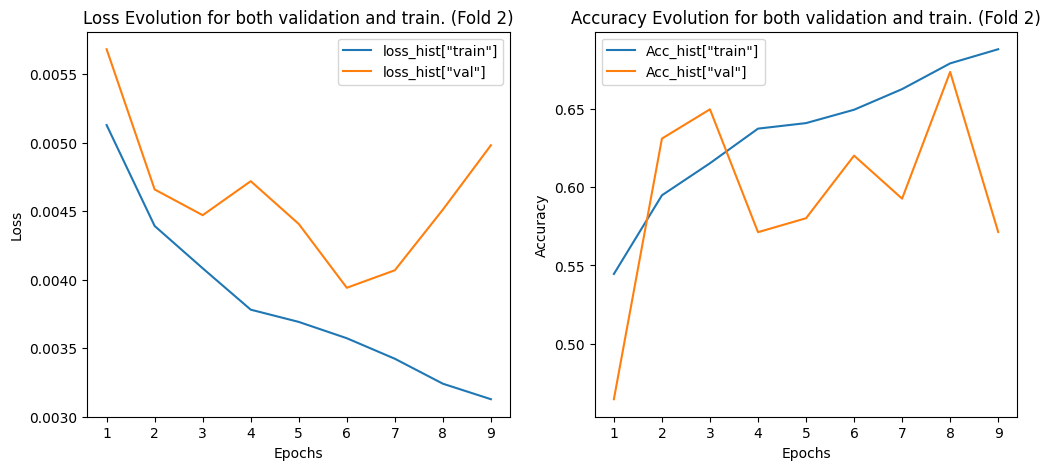

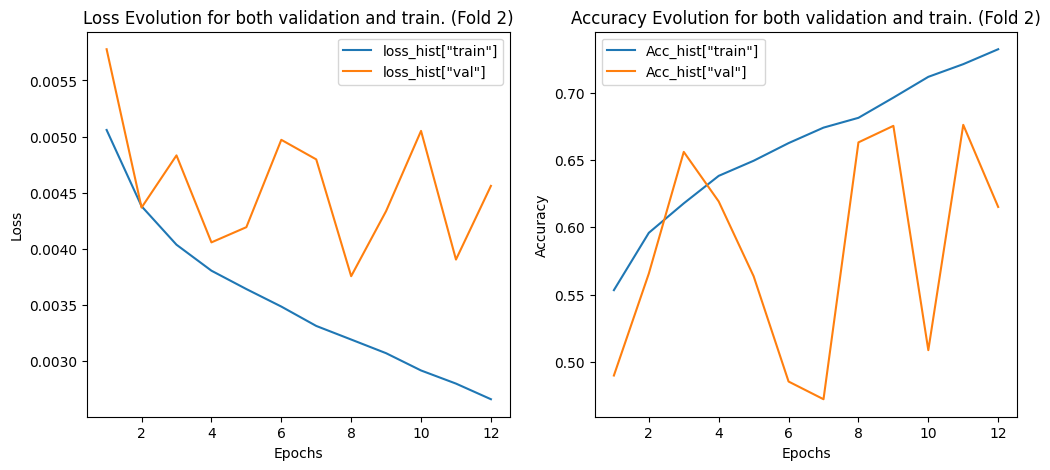

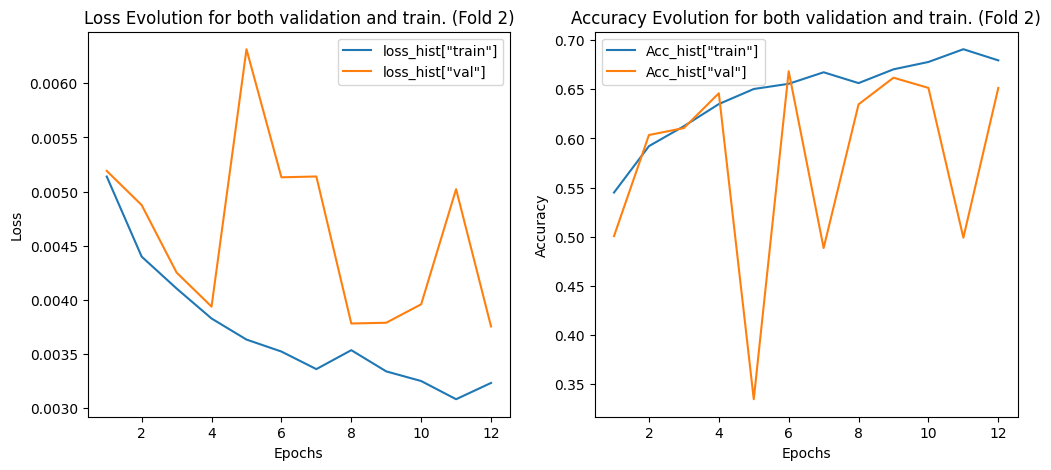

In [ ]:
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
from torchvision.models import resnet18, ResNet18_Weights,efficientnet_b4
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score,  roc_auc_score, accuracy_score
import statistics
import statistics
from prettytable import PrettyTable
import copy

metric_hist_list3 = []
loss_hist_list3 = []
resnet_model_list3 = []
best_model_wts_list3 = []


min_worst_f1_score2 = float('inf')
min_iteration = -1

max_best_f1_score2 = -float('inf')
max_iteration = -1



auc_list3 = []
precision_list3 = []
recall_list3 = []
f1_score_list3 = []

auc_list4 = []
precision_list4 = []
recall_list4 = []
f1_score_list4 = []
accuracy_score_list3 = []
accuracy_score_list4 = []


metric_hist_list4 = []
loss_hist_list4 = []
resnet_model_list4 = []
best_model_wts_list4 = []
time_list = []
import time


for index_val in range(3):

    s = time.time()
    cnn_model = resnet18(weights=None)
    num_ftrs = cnn_model.fc.in_features
    cnn_model.fc = nn.Linear(num_ftrs, 6)
    if torch.cuda.is_available():
        cnn_model.cuda()
    if torch.cuda.device_count() > 1:
        cnn_model = nn.DataParallel(cnn_model)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    cnn_model.to(device)
    X_train = df2.loc[train_min_index]
    X_val = df2.loc[val_min_index]
    files_with_train = X_train['Image'].to_list()
    files_with_val = X_val['Image'].to_list()
    files_train = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_train, hemDatTrain.file_location))
    files_val = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_val, hemDatTrain.file_location))
    df_Train = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_train['Image'].to_list())]
    df_Val = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_val['Image'].to_list())]
    df_Val = pd.concat([df_Val], ignore_index=True)
    df_Train = pd.concat([df_Train], ignore_index=True)

    hemDatTrain3 = HemorrhageDataset(files_train, df_Train, special_transform2, True, True)
    hemDatVal2 = HemorrhageDataset(files_val, df_Val, normal_transform, True, False)

    batch_size = 64

    num_weight = get_pos_weights(hemDatTrain3.df)
    sampler_pos_weight = get_sampler_pos_weight(hemDatTrain3.df, num_weight)
    num_weight = num_weight.to(device)
    sampler = WeightedRandomSampler(sampler_pos_weight, len(sampler_pos_weight))
    train_loader = None

    train_loader = torch.utils.data.DataLoader(hemDatTrain3, sampler=sampler, batch_size = batch_size, shuffle = False, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(hemDatVal2, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(hemDatTest, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)


    val_shape = ()
    out_shape = ()
    for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
        for X, y in value:
            val_shape = X.shape
            out_shape = y.shape

            print(f"Shape of X : {X.shape}")
            print(f"{key}:")
            print(f"Shape of X : {X.shape}")
            print(f"Shape of y: {y.shape} {y.dtype}\n")
            break

    loss_function = torch.nn.BCEWithLogitsLoss()


    optimiser = None
    lr_change = None
    limit=False

    optimizer = optim.Adam(cnn_model.parameters(),lr=1e-4, weight_decay=1e-4)
    if index_val == 0:
        limit=True
    elif index_val == 1:
        lr_change = StepLR(optimizer,
                        step_size=3,
                        gamma=0.1)
    elif index_val == 2:
        lr_change = ReduceLROnPlateau(optimizer,
                                    mode='min',
                                    factor=0.5,
                                    patience=2)
    params_train={
     "train": train_loader,"val": val_loader,
     "epochs": 12,
     "optimiser": optimizer,
     "lr_change": lr_change,
     "f_loss": loss_function,
     "weight_path": "weights.pt",
    }

    resnet_model,loss_hist,metric_hist,best_model_wts = Train_Val(cnn_model,params_train, verbose=True, limit=limit, s=s)

    time_current2 = f"{time_current//3600} h {(time_current - (time_current//3600)*3600)//60} minutes {time_current-(time_current//3600)*3600-((time_current - (time_current//3600)*3600)//60)*60} seconds"
    time_list.append(time_current2)

    metric_hist_list4.append(metric_hist)
    loss_hist_list4.append(loss_hist)
    resnet_model_list4.append(resnet_model)
    best_model_wts_list4.append(best_model_wts)


    for idx, (train, val) in enumerate(zip(metric_hist['train'], metric_hist['val'])):
        print(f"Iteration {idx}. Accurracy for train :{train*100}. Accurracy for val :{val*100}")
    for idx, (train, val) in enumerate(zip(loss_hist['train'], loss_hist['val'])):
        print(f"Iteration {idx}. Loss for train :{train}. Loss for val :{val}")


    # Convergence History Plot
    epochs=params_train["epochs"]
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    list_metric_train = list(map(lambda x: x, metric_hist["train"]))
    list_metric_val = list(map(lambda x: x, metric_hist["val"]))

    sns.lineplot(x=[*range(1,len(loss_hist["train"])+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
    sns.lineplot(x=[*range(1,len(loss_hist["val"])+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')

    ax[0].set_title(f"Loss Evolution for both validation and train. (Fold {fold+1})")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()


    sns.lineplot(x=[*range(1,len(metric_hist["train"])+1)],y=list_metric_train,ax=ax[1],label='Acc_hist["train"]')
    sns.lineplot(x=[*range(1,len(metric_hist["val"])+1)],y=list_metric_val,ax=ax[1],label='Acc_hist["val"]')
    ax[1].set_title(f"Accuracy Evolution for both validation and train. (Fold {fold+1})")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()


    print("Time for training ", time_current2)
    loss_func = torch.nn.BCEWithLogitsLoss()
    y_true, y_pred = Ture_and_Pred(test_loader, resnet_model, device)

    metric_b=roc_auc_score(y_pred, y_true)
    accuracy_s = accuracy_score(y_pred, y_true)
    _acc = metric_b
    _f1_score = f1_score(y_true, y_pred, average='macro')
    _recall = recall_score(y_true, y_pred, average='macro')
    _precision = precision_score(y_true, y_pred, average='macro')
    auc_list3.append(_acc)
    precision_list3.append(_precision)
    recall_list3.append(_recall)
    f1_score_list3.append(_f1_score)
    accuracy_score_list3.append(accuracy_s)

    print(f"For test:\n auc:{metric_b}\n accuracy:{accuracy_s}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n ")

    if _f1_score < min_worst_f1_score2:
        min_worst_f1_score2 = _f1_score
        min_iteration = index_val



    if _f1_score > max_best_f1_score2:
        max_best_f1_score = _f1_score
        max_iteration = index_val


    y_true, y_pred = Ture_and_Pred(val_loader, resnet_model, device)

    metric_b=roc_auc_score(y_pred, y_true)
    accuracy_s = accuracy_score(y_pred, y_true)
    _acc = metric_b
    _f1_score = f1_score(y_true, y_pred, average='macro')
    _recall = recall_score(y_true, y_pred, average='macro')
    _precision = precision_score(y_true, y_pred, average='macro')
    auc_list4.append(_acc)
    precision_list4.append(_precision)
    recall_list4.append(_recall)
    f1_score_list4.append(_f1_score)
    accuracy_score_list4.append(accuracy_s)


    print(f"For validation:\n auc:{metric_b}\n accuracy:{accuracy_s}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n ")







In [ ]:
import statistics
from prettytable import PrettyTable
table = PrettyTable(["Column","AUC", "Accuracy", "F1-score", "Precision", "Recall"])

for i in range(3):
    str_column = ""
    if i==0:
        str_column = "Early Stop"
    elif i==1:
        str_column = "LR Scheduler - StepLR"
    else:
        str_column = "LR Scheduler - ReduceLROnPlateau"
    table.add_row([f"{str_column} Test", auc_list3[i], accuracy_score_list3[i], f1_score_list3[i], precision_list3[i],recall_list3[i]])
    table.add_row([f"{str_column} Val", auc_list4[i], accuracy_score_list4[i], f1_score_list4[i], precision_list4[i],recall_list4[i]])

print(table)

+---------------------------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|                 Column                |        AUC         |       Accuracy      |      F1-score      |     Precision      |       Recall       |
+---------------------------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|            Early Stop Test            | 0.700925734694254  | 0.26620968648162713 | 0.5784004803489543 | 0.6545457291657791 | 0.5651860236386398 |
|             Early Stop Val            | 0.7891443819319847 |  0.6202453227605006 | 0.568639642499393  | 0.6495297582806613 | 0.5441518918364968 |
|       LR Scheduler - StepLR Test      |  0.70309285162593  | 0.29295426452410384 | 0.5752429270885916 | 0.6753477678060292 | 0.5387418601294011 |
|       LR Scheduler - StepLR Val       | 0.8184353485319967 |  0.6631148556560525 | 0.5946581275883268 | 0.7124

Pentru cerinta 5, cel mai slab model pana acum a fost fold 0 din punct de vedere al perfomantei, deoarece, avem de a face cu overfitting, din cauza performantelor slabe pe setul de test.

THIS PART IS FOR TASK 1+2+3+4